## 삼체문제

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})
#%config InlineBackend.figure_format='retina'

In [2]:
def embedded_rk4_ode(f, y0, h0, xlim, abstol=0, reltol=1e-7, hminmax=(1e-30, 1e30),
                     max_iterations=2**30, should_trim_endpoint=True):
    """Approximate the solution of y' = f(y, x) by embedded 4th-order Runge-Kutta method.
    
    :param f:
        Right-hand side of the differential equation y' = f(y, x).
    :param y0:
        Initial value y0 = y(x0) where x0 is the first element of list xlim.
    :param h0:
        Initial stepsize.
    :param xlim:
        A pair of values denoting the integral limit.
    :param abstol=float:
        Absolute error tolerence needed.
    :param reltol=float:
        Relative error tolerence needed.
    :param hminmax=(hmin, hmax):
        The minimum and maximum stepsizes in which the next stepsize must lie.
    :param max_iterations=integer:
        The maximum number of iterations allowed.
    :param should_trim_endpoint=boolean:
        If True, modify the last approximation to the value at x = xlim[1].
        
    :return:
    Returns x values, y values, and step sizes.
    """

    x0, xf = xlim

    # table
    a2 , a3 , a4 , a5 , a6  = 1/5, 3/10, 3/5, 1, 7/8
    b21, b31, b41, b51, b61 = 1/5, 3/40, 3/10, -11/54, 1631/55296
    b32, b42, b52, b62      = 9/40, -9/10, 5/2, 175/512
    b43, b53, b63           = 6/5, -70/27, 575/13824
    b54, b64                = 35/27, 44275/110592
    b65                     = 253/4096
    #
    c1, c2, c3, c4, c5, c6  = 37/378, 0, 250/621, 125/594, 0, 512/1771
    d1, d2, d3              = c1 - 2825/27648, c2 - 0, c3 - 18575/48384
    d4, d5, d6              = c4 - 13525/55296, c5 - 277/14336, c6 - 1/4

    def single_step(x, y, h):
        k1 = h*f(x       , y)
        k2 = h*f(x + a2*h, y + b21*k1)
        k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
        k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
        k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
        k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)
        
        # approximation of y
        y = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6
        x = x + h

        # error estimate
        delta = d1*k1 + d2*k2 + d3*k3 + d4*k4 + d5*k5 + d6*k6
        
        y_tmp = abs(y) + abs(h*k1) # this is to prevent y ≈ 0
        desired = abs(abstol) + abs(y_tmp*reltol)
        rel_err = delta / desired
        if type(rel_err) is not float:                                  # in case of ndarray,
            rel_err = np.sqrt(sum(rel_err.flatten()**2) / len(rel_err)) # take square norm

        # next step size
        h = h / max(abs(rel_err)**0.2, 1e-2)    # limit the max stepsize increase
        h = min(max(h, hminmax[0]), hminmax[1]) # finally, clamp stepsize

        return x, y, h
    
    # loop
    xs = [x0]
    ys = [y0]
    hs = [h0]
    i  = 0
    while i < max_iterations and x0 < xf:
        x0, y0, h0 = single_step(x0, y0, h0)
        xs.append(x0)
        ys.append(y0)
        hs.append(h0)
        i += 1
        
    if should_trim_endpoint:
        xs[-1], ys[-1], _ = single_step(xs[-2], ys[-2], xf - xs[-2])
    return xs, ys, hs

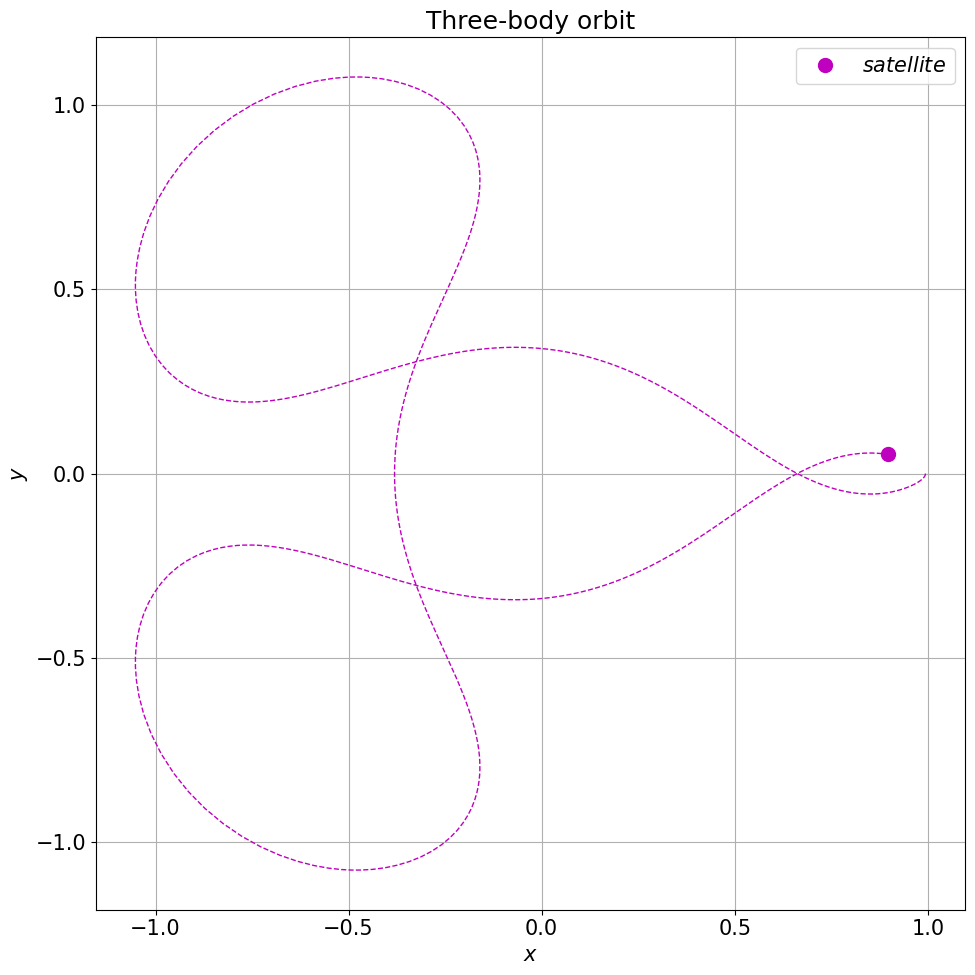

In [22]:
#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994 ,0,0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.0001

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 3.5* np.pi 
abstol = 0
reltol = 1e-9

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew_dot *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew_dot * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])



plt.plot(xlist, ylist, '--m', lw=1 )
plt.plot(xlist[-1],ylist[-1], 'om', ms=10,label="$satellite$")

"""
plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(1 - mew, 0, 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(-mew, 0,  'or', ms=10, label="$Moon$")
"""
plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.savefig('Three1.pdf')




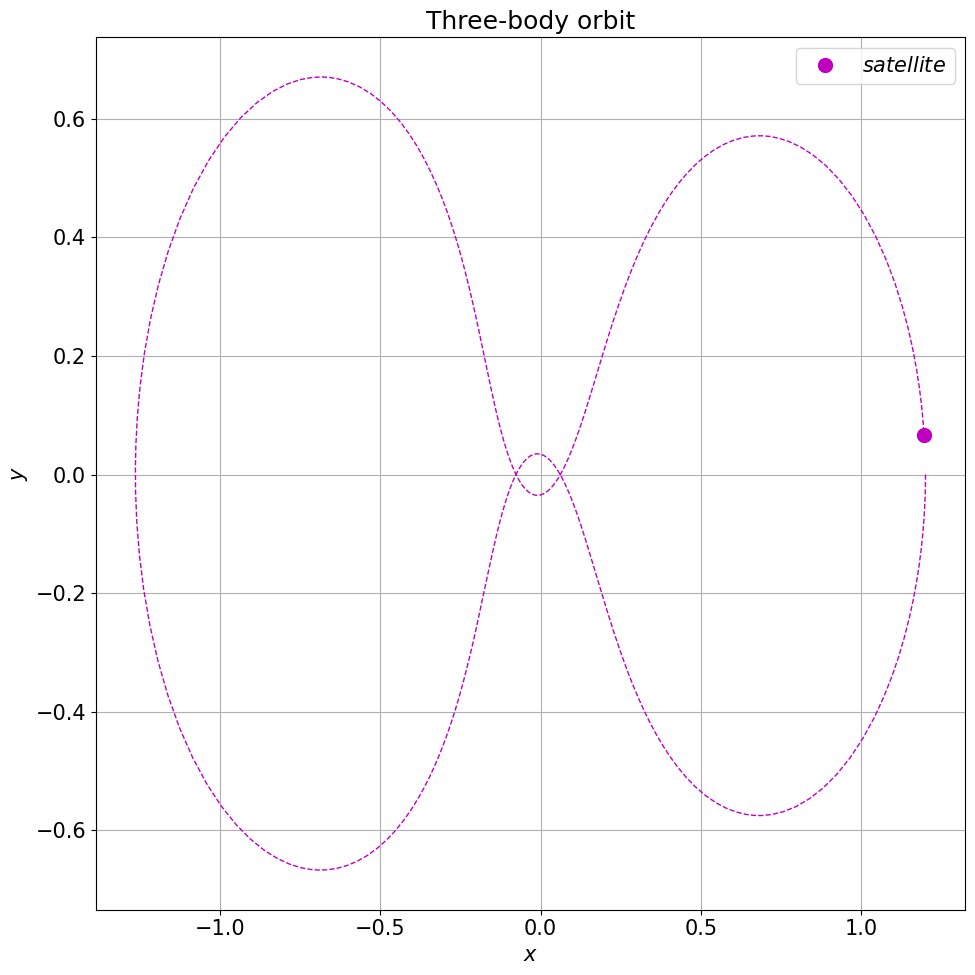

In [35]:
#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [1.2 ,0,0, -1.04935751] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.0001

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 1.95* np.pi 
abstol = 0
reltol = 1e-9

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew_dot *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew_dot * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])



plt.plot(xlist, ylist, '--m', lw=1 )
plt.plot(xlist[-1],ylist[-1], 'om', ms=10,label="$satellite$")

"""
plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(1 - mew, 0, 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(-mew, 0,  'or', ms=10, label="$Moon$")
"""
plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.savefig('Three1.pdf')




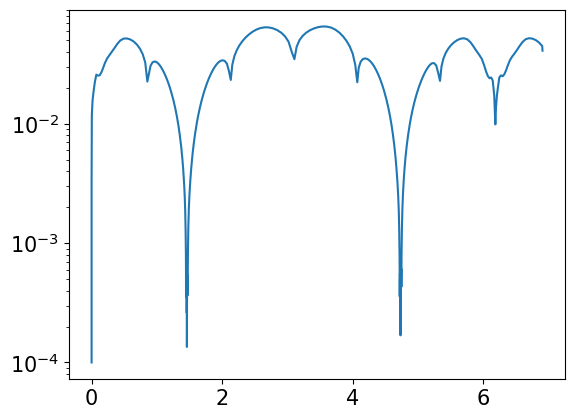

In [33]:
plt.semilogy(t, h)


# Y_init 수정 후에 값이 어떻게 변하는지 보자

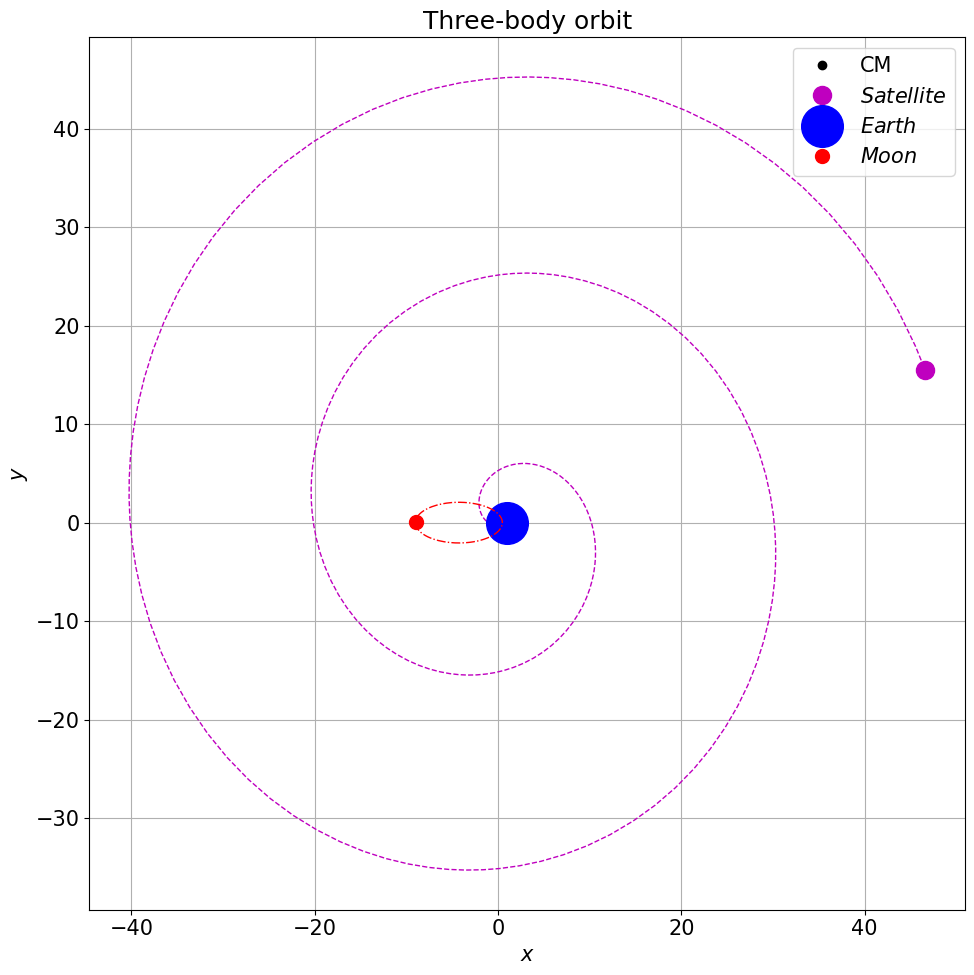

In [283]:
#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = abstol

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-1],ylist[-1] ,'om', ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.savefig('Three2.pdf')

## 다른 오차를 부여하여 풀어보자.

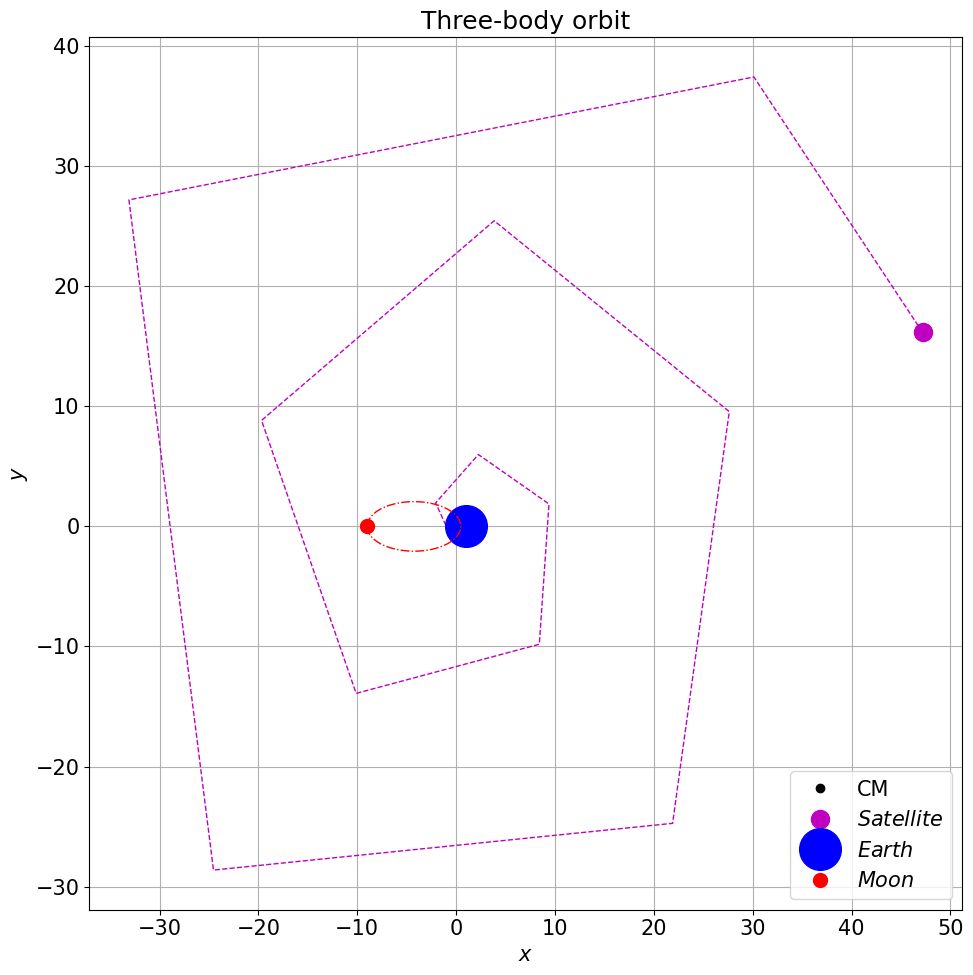

In [289]:
#오차를 1e-3

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-3
reltol = abstol

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-1], ylist[-1],'om', ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.savefig('Three3.pdf')

In [7]:
## 다른 오차를 부여하여 풀어보자. abs = 1e-5

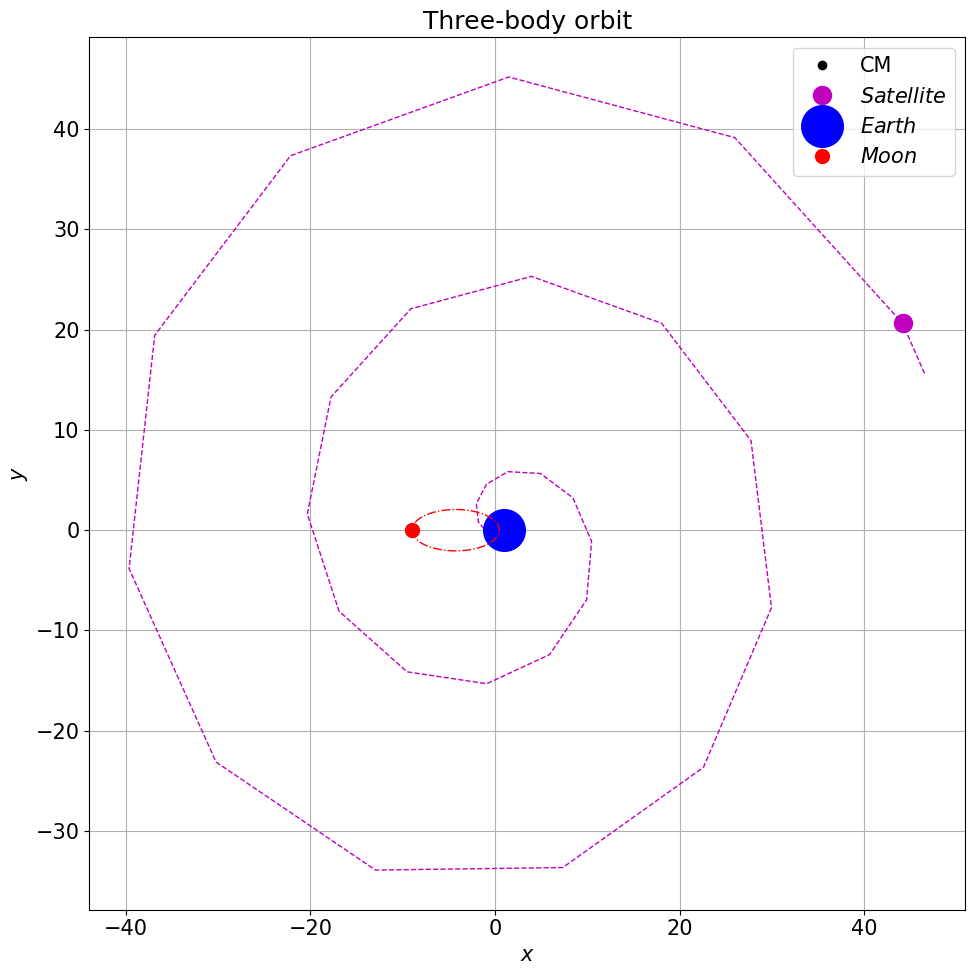

In [290]:
#오차를 1e-3

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-5
reltol = abstol

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], ylist[-2],'om', ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.savefig('Three4.pdf')

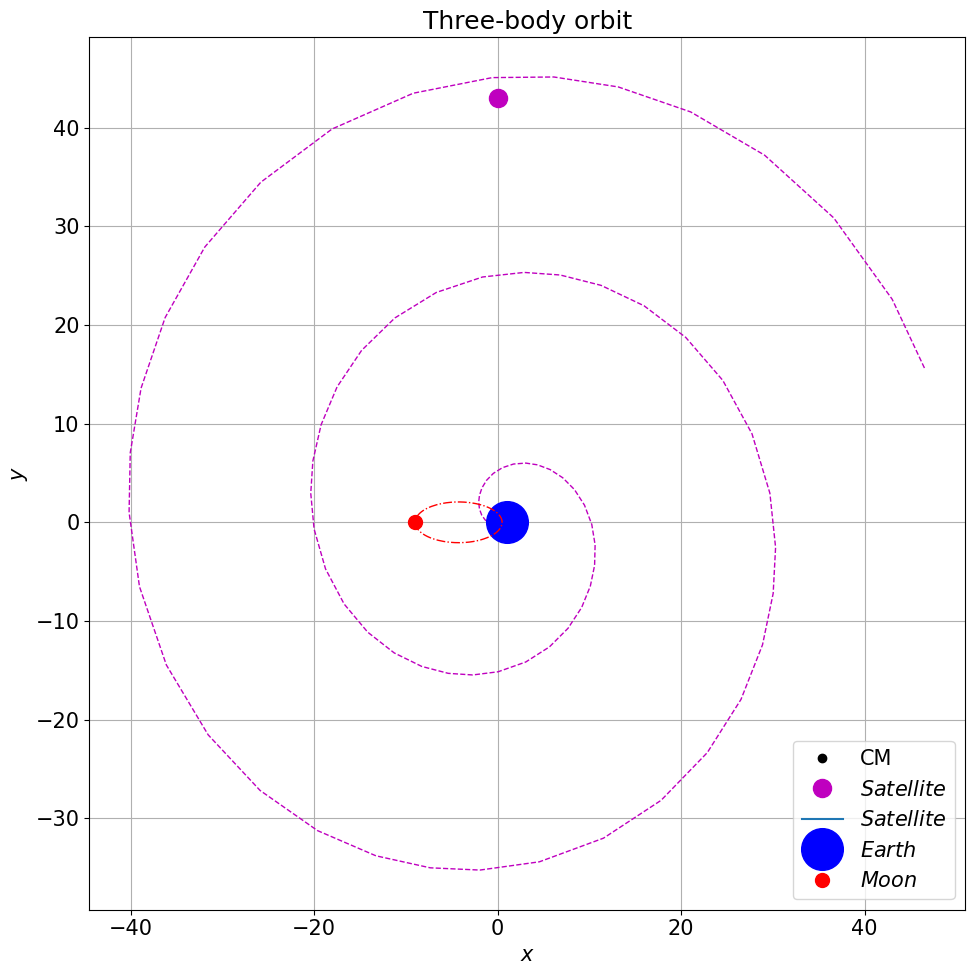

In [9]:
#오차를 1e-7

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-7
reltol = abstol

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], 'om',ylist[-2], ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.show()

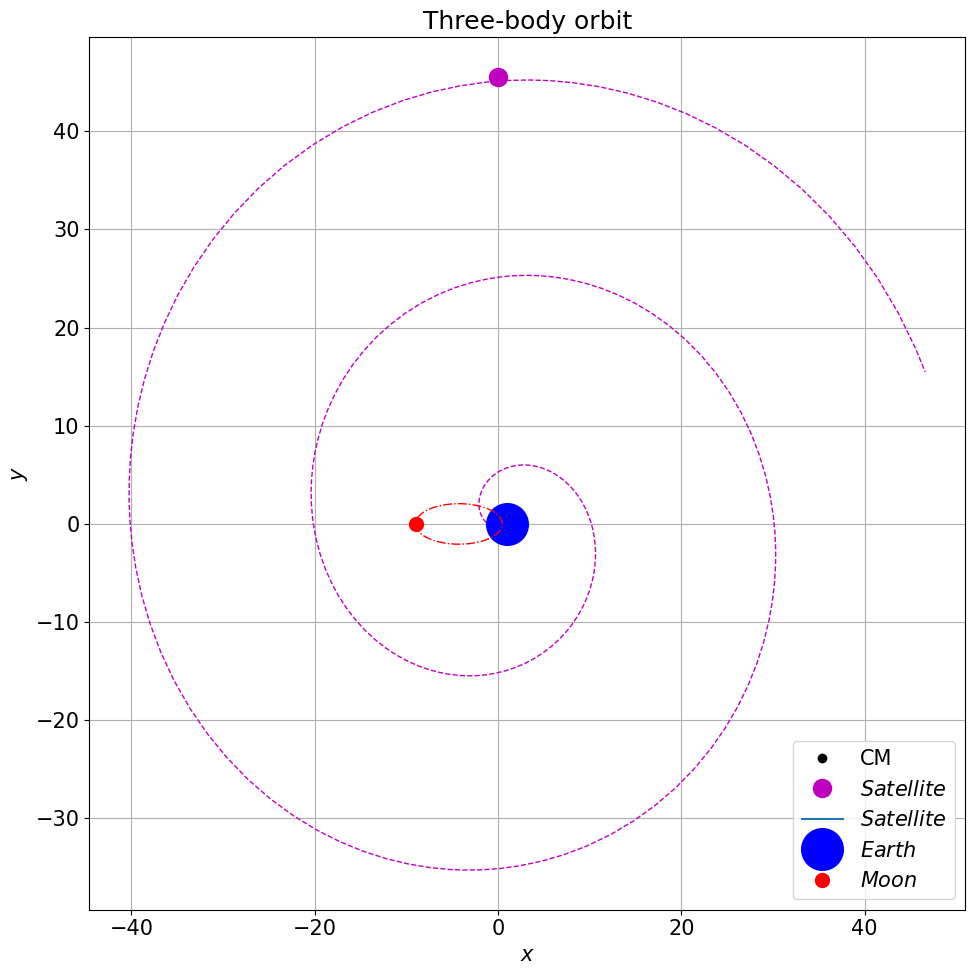

In [10]:
#오차를 1e-3

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = abstol

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], 'om',ylist[-2], ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.show()

## abstol 고정인 상태에서 retol을 수정 retol = 1e-3일때

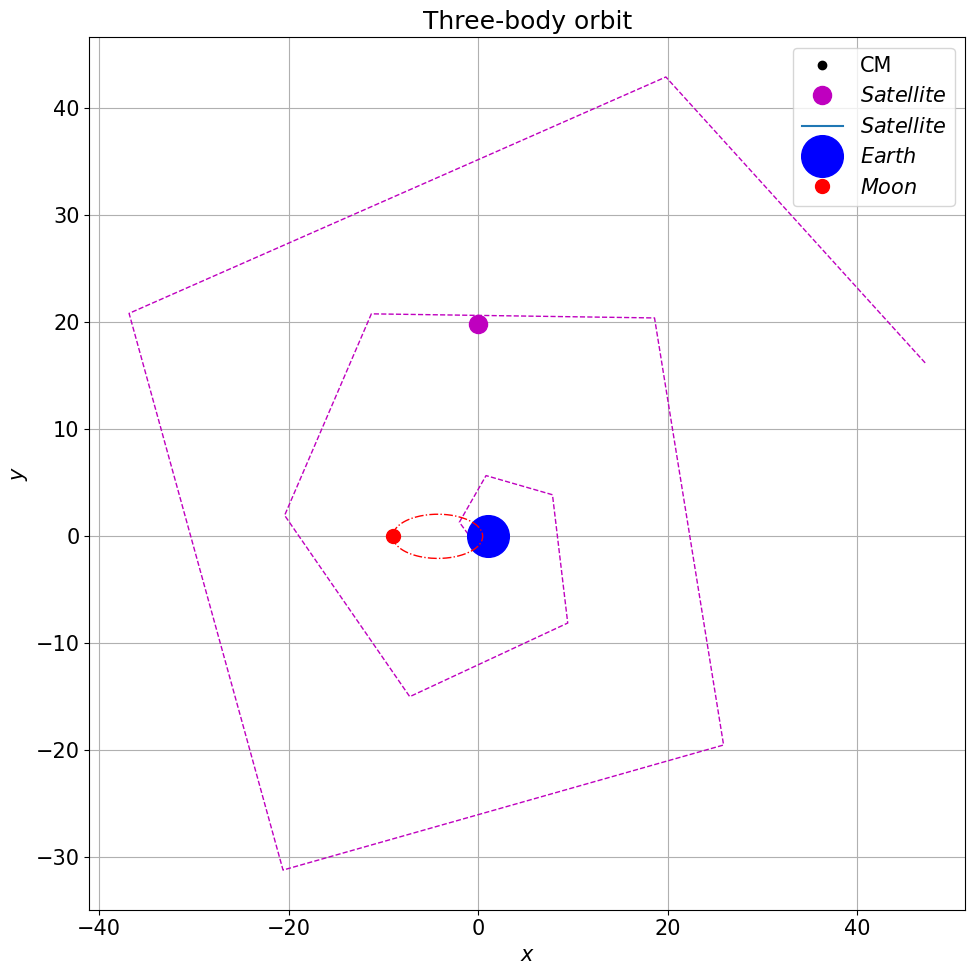

In [11]:
#오차를 1e-3

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = 1e-3

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], 'om',ylist[-2], ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()


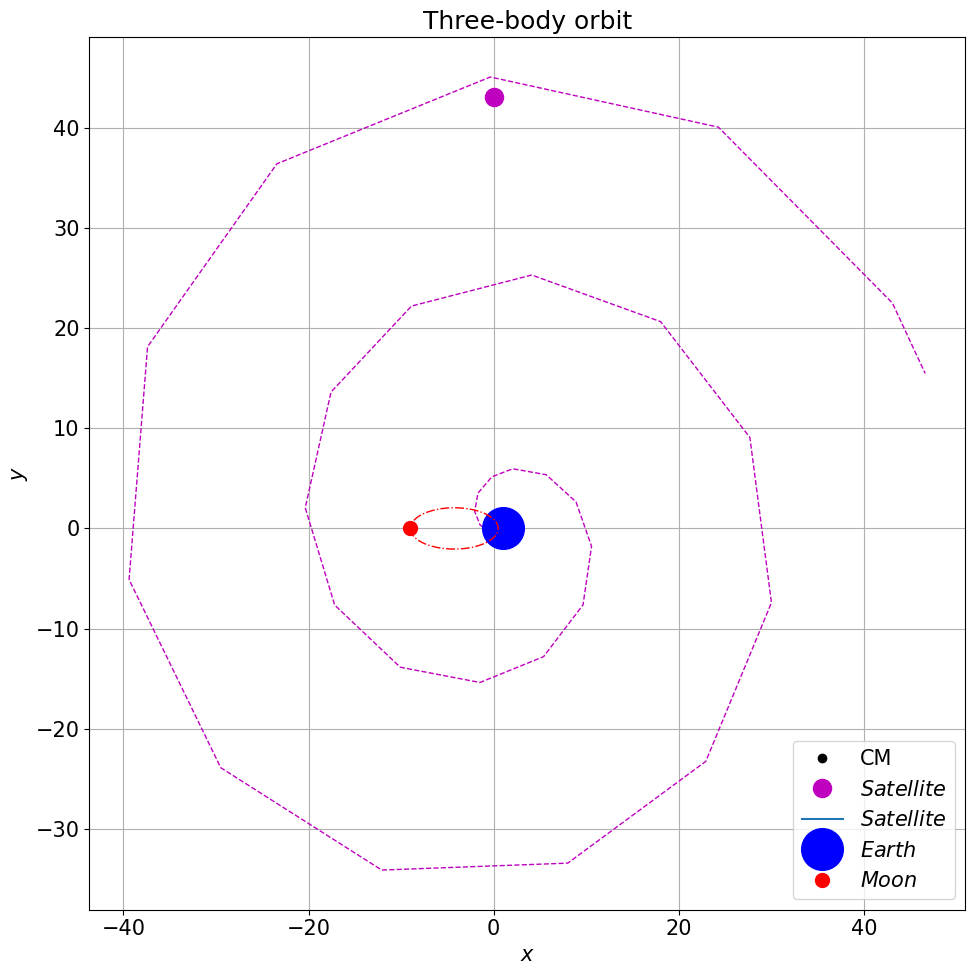

In [12]:
#오차를 1e-5

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = 1e-5

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], 'om',ylist[-2], ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.show()

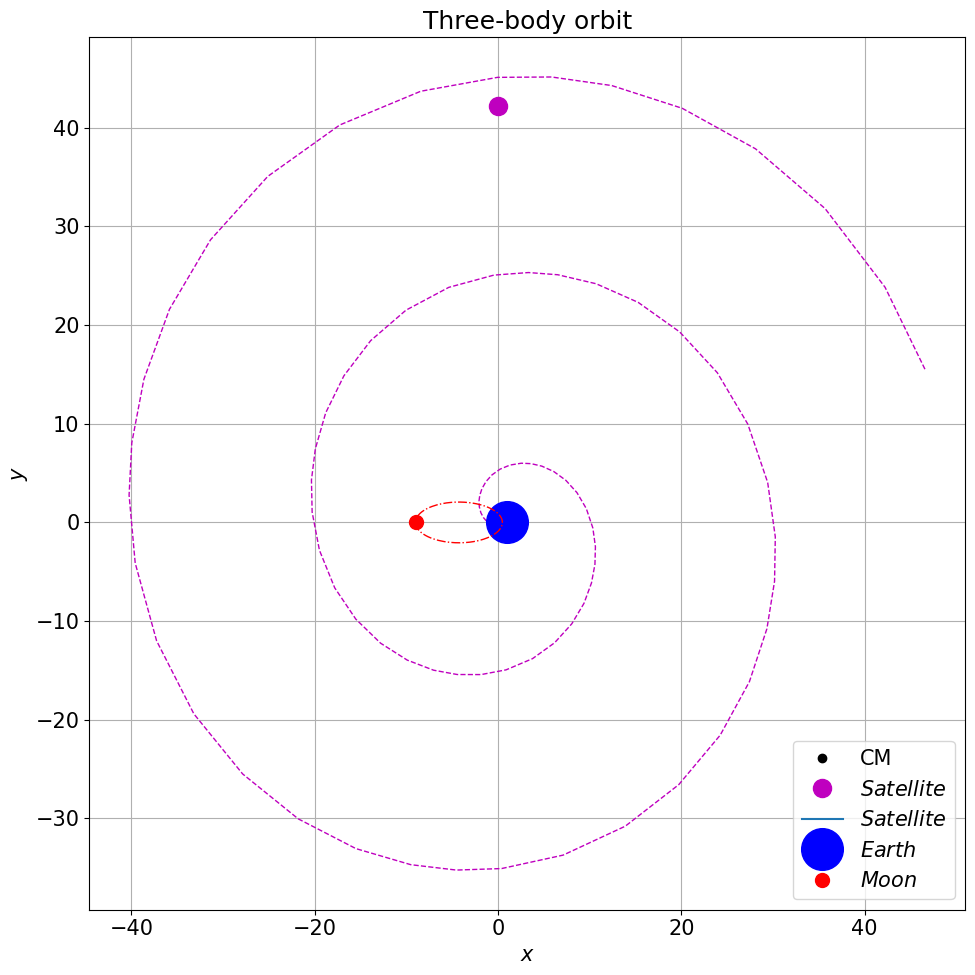

In [13]:
#오차를 1e-3

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = 1e-7

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], 'om',ylist[-2], ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.show()

# abs, rel 둘다 오차를 변형했을 경우

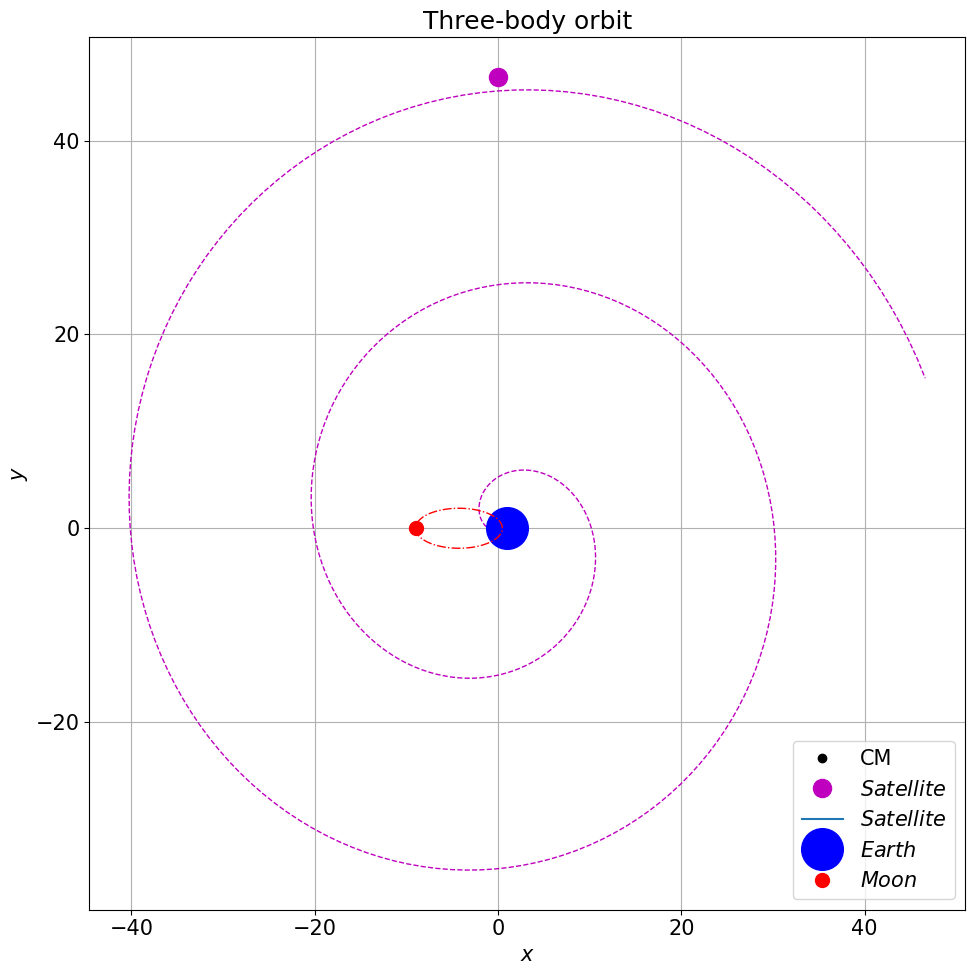

In [14]:
#오차를 1e-3

#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = 1e-30

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], 'om',ylist[-2], ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.show()

#### 결론은 둘다 균형있게 차이가 적어야 더 확실한 원을 그린다. 확실한 Solution을 보여준다는 것.

# Stepsize에 따른 변화?
#### 한 세트의 초기조건에서 Integration of ODES가 진행됨에 따라 ODE 루틴에서 Stepsize를 Modeling하는 Stepsize는 언제 커지다가 작아질까?

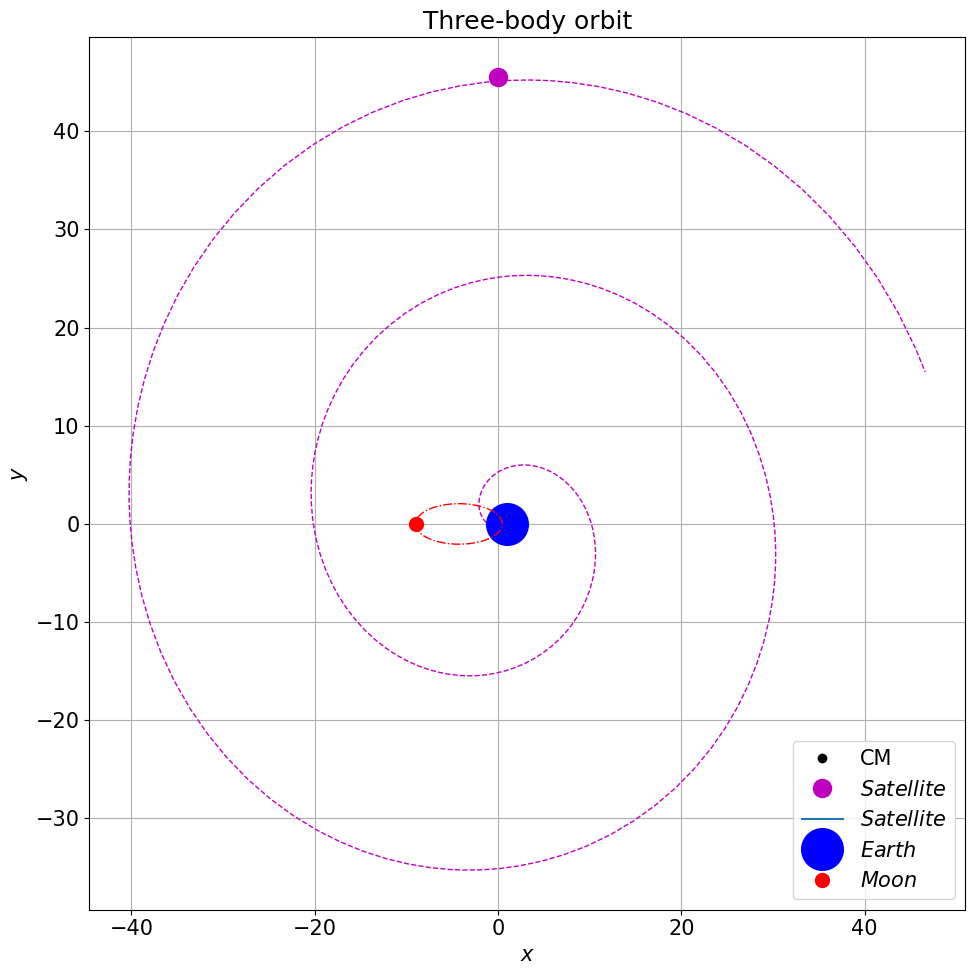

In [15]:
#Constant
mew = 1 / 81.45
mew_dot = 1 - mew


#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = 1e-9

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))

#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(0, 0, 'ok', label="CM")

plt.plot(xlist, ylist, '--m', lw=1)
plt.plot(xlist[-2], 'om',ylist[-2], ms=13, label="$Satellite$")

plt.plot(*zip(*xx1), '--b', lw=1)
plt.plot(*xx1[-1, :], 'ob', ms=30, label="$Earth$")

plt.plot(*zip(*xx2), '-.r', lw=1)
plt.plot(*xx2[-1, :], 'or', ms=10, label="$Moon$")

plt.legend()
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Three-body orbit")

plt.tight_layout()
plt.show()

In [18]:
#초기조건에서만 분석할 Stepsize 와 x0 사이의 관계 분석.
def embedded_rk4_ode_1(f, y0, h0, xlim, abstol=0, reltol=1e-7, hminmax=(1e-30, 1e30),
                     max_iterations=2**30, should_trim_endpoint=True):
    """Approximate the solution of y' = f(y, x) by embedded 4th-order Runge-Kutta method.
    
    :param f:
        Right-hand side of the differential equation y' = f(y, x).
    :param y0:
        Initial value y0 = y(x0) where x0 is the first element of list xlim.
    :param h0:
        Initial stepsize.
    :param xlim:
        A pair of values denoting the integral limit.
    :param abstol=float:
        Absolute error tolerence needed.
    :param reltol=float:
        Relative error tolerence needed.
    :param hminmax=(hmin, hmax):
        The minimum and maximum stepsizes in which the next stepsize must lie.
    :param max_iterations=integer:
        The maximum number of iterations allowed.
    :param should_trim_endpoint=boolean:
        If True, modify the last approximation to the value at x = xlim[1].
        
    :return:
    Returns x values, y values, and step sizes.
    """

    x0, xf = xlim

    # table
    a2 , a3 , a4 , a5 , a6  = 1/5, 3/10, 3/5, 1, 7/8
    b21, b31, b41, b51, b61 = 1/5, 3/40, 3/10, -11/54, 1631/55296
    b32, b42, b52, b62      = 9/40, -9/10, 5/2, 175/512
    b43, b53, b63           = 6/5, -70/27, 575/13824
    b54, b64                = 35/27, 44275/110592
    b65                     = 253/4096
    #
    c1, c2, c3, c4, c5, c6  = 37/378, 0, 250/621, 125/594, 0, 512/1771
    d1, d2, d3              = c1 - 2825/27648, c2 - 0, c3 - 18575/48384
    d4, d5, d6              = c4 - 13525/55296, c5 - 277/14336, c6 - 1/4

    def single_step(x, y, h):
        k1 = h*f(x       , y)
        k2 = h*f(x + a2*h, y + b21*k1)
        k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
        k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
        k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
        k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)
        
        # approximation of y
        y = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6
        x = x + h

        # error estimate
        delta = d1*k1 + d2*k2 + d3*k3 + d4*k4 + d5*k5 + d6*k6
        
        y_tmp = abs(y) + abs(h*k1) # this is to prevent y ≈ 0
        desired = abs(abstol) + abs(y_tmp*reltol)
        rel_err = delta / desired
        #print(f"rel_err: {rel_err}")
        #print(f"h : {h}")
        h_list.append(abs(h))
        rel_err_list.append(abs(rel_err[0]))
        #x의 값 변화만 먼저 비교
        


        if type(rel_err) is not float:                                  # in case of ndarray,
            rel_err = np.sqrt(sum(rel_err.flatten()**2) / len(rel_err)) # take square norm
        
        # next step size
        h = h / max(abs(rel_err)**0.2, 1e-2)    # limit the max stepsize increase
        h = min(max(h, hminmax[0]), hminmax[1]) # finally, clamp stepsize
        
        return x, y, h
    
    # loop
    xs = [x0]
    ys = [y0]
    hs = [h0]
    i  = 0
    while i < max_iterations and x0 < xf:
        x0, y0, h0 = single_step(x0, y0, h0)
        xs.append(x0)
        ys.append(y0)
        hs.append(h0)
        
        i += 1
        
    if should_trim_endpoint:
        xs[-1], ys[-1], _ = single_step(xs[-2], ys[-2], xf - xs[-2])
    return xs, ys, hs

In [17]:
#Constant
mew = 1 / 81.45
mew_dot = 1 - mew
h_list = []
rel_err_list = []

#For solution, setting
Y_init = [0.994, 0, 0, -2.03173262956] #[x(0), y(0), v_x(0), v_y(0)]
h_init = 0.1

# Must editing!!!! Tolerence and tlim setting
tlim = 0, 5 * np.pi 
abstol = 1e-9
reltol = 1e-9

#editting 고려사항
m = 1 #settlelite mass, 무시 가능한데, F = ma 를 위해서는 적어주긴 해야함

def F(t, Y): 
    """
    Function for settlelite 
    F = [dx/dt, 
         dy/dt, 
         dv_x/dt,
         dv_y/dt]
    """
    x, y, v_x, v_y = Y
    r_1 = ((x + mew)**2 + y**2)**0.5 #r_1**2을 r_1에 대한 식으로
    r_2 = ((x - mew_dot)**2 + y**2)**0.5
    
    #For (x, y) location --> F/m  = a
    F_x = 2 * v_y + x - ((mew *(x + mew)) / r_1**3) - ((mew * (x - mew_dot)) / r_2**3) 
    F_y = -2 * v_x + y - ((mew * y) / r_1**3) - ((mew * y) / r_2**3)
    
    return np.array([v_x, v_y, F_x / m, F_y / m])

#Solution zip -> map!
t, Y, h = embedded_rk4_ode_1(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 10), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*Y))



#Plotting (x, y)!!
plt.figure(figsize=[10, 10])

plt.plot(diff_rel_err, h_list[2:] - h_list[1:], '.r')
plt.legend()
plt.grid()
plt.xlabel("$rel_{err}$")
plt.ylabel("$h$")
plt.title("h & rel_{err} Graph")

plt.tight_layout()
plt.show()



NameError: name 'diff_rel_err' is not defined

<Figure size 1000x1000 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (1164,) and (232,)

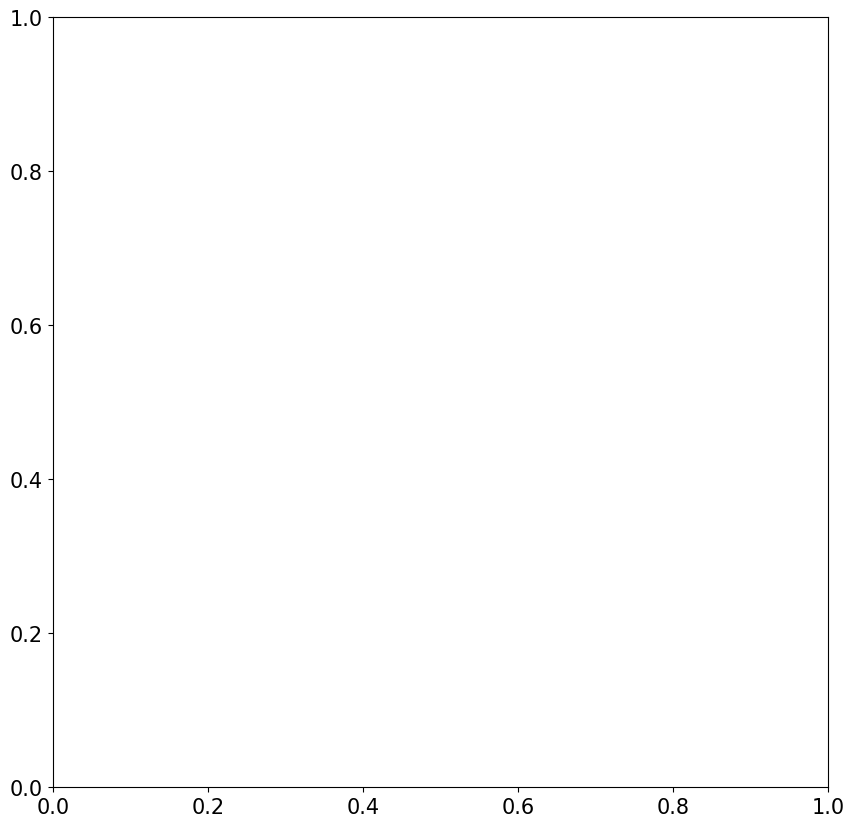

In [202]:
#rel_err_list[2:] - rel_err_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
rel_err_2 = rel_err_list[2:] # 2부터 시작하는 리스트
rel_err_2.append(rel_err_list[-1]) # 마지막 요소 추가
diff_rel_err = []

for i, j in zip(rel_err_2, rel_err_list[1:]):
    diff_rel_err.append(i - j)

h_list_2 = h_list[2:]
h_list_2.append(h_list[-1])
diff_h_list = []

for i, j in zip(h_list_2, h_list):
    diff_h_list.append(i - j)
    
#Plotting (x, y)!!
plt.figure(figsize=[10, 10])

plt.plot(diff_rel_err, diff_h_list, '.r')
plt.legend()
plt.grid()
plt.xlabel("$rel_{err}$")
plt.ylabel("$h$")
plt.title("h & rel_{err} Graph")

plt.tight_layout()
plt.show()




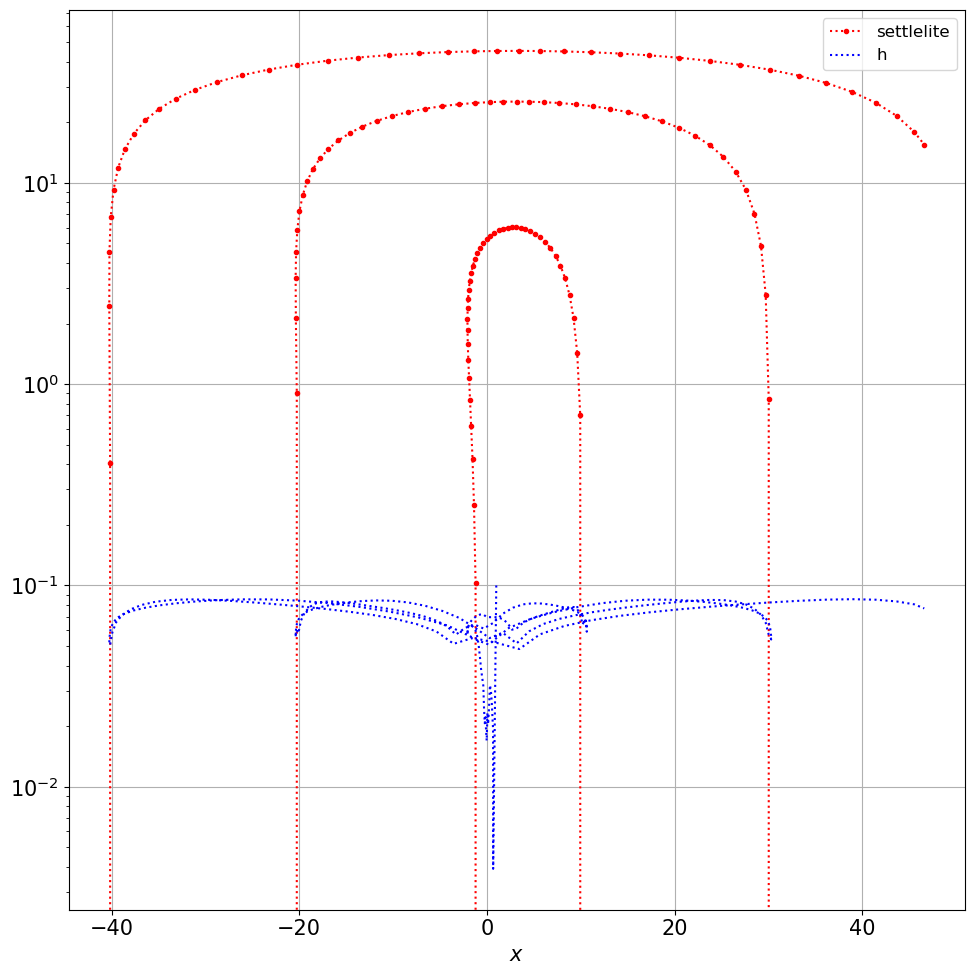

In [301]:
xlim = 0, 
abstol = 1e-9
reltol = 1e-9
xs, ys, hs = embedded_rk4_ode_1(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 1e5), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*ys))

plt.figure(figsize=[10, 10])
plt.semilogy(xlist, ylist, ".:r",xlist, hs, ":b")
plt.legend(["settlelite", "h"], fontsize=12)
plt.grid()
plt.xlabel("$x$")

plt.tight_layout()

plt.tight_layout()
plt.show()

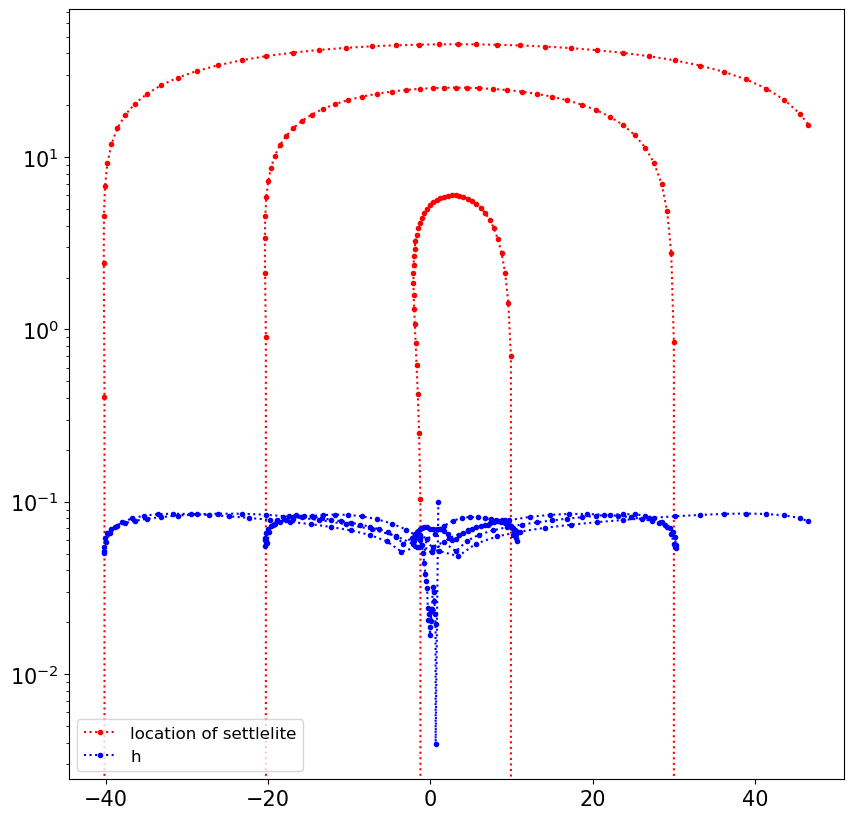

In [304]:
plt.figure(figsize=[10, 10])
plt.semilogy(xlist, ylist, ".:r",xlist, hs, ".:b")
plt.legend(["location of settlelite", "h"], fontsize=12)

plt.savefig("xandhs.pdf")

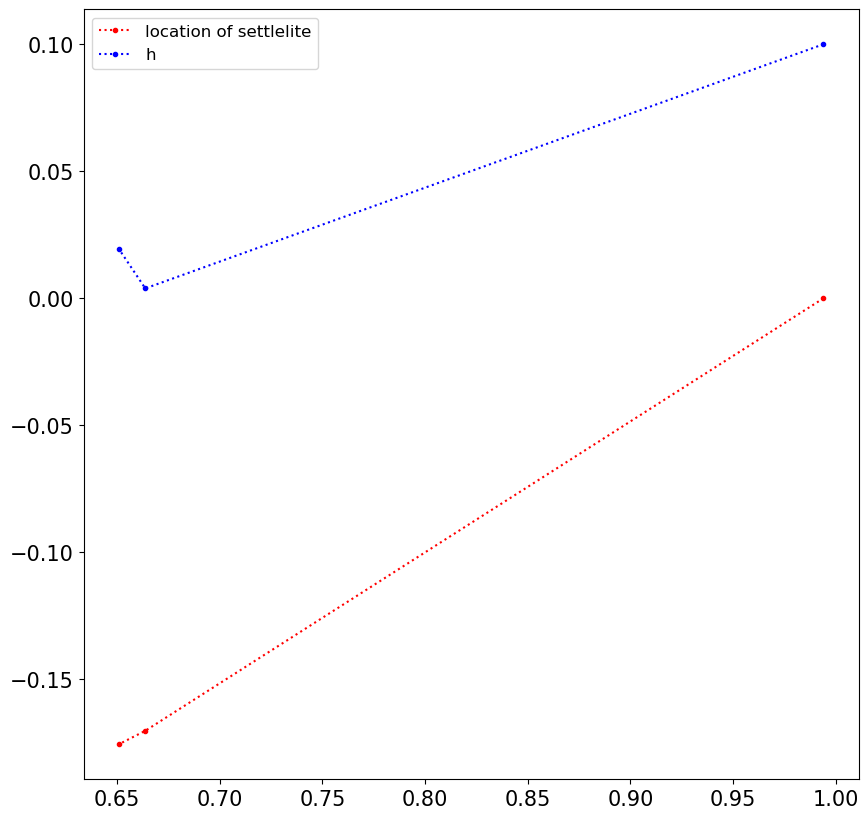

In [307]:
plt.figure(figsize=[10, 10])
plt.plot(xlist[:-230], ylist[:-230], ".:r",xlist[:-230], hs[:-230], ".:b")
plt.legend(["location of settlelite", "h"], fontsize=12)
plt.savefig("xandhs2.pdf")

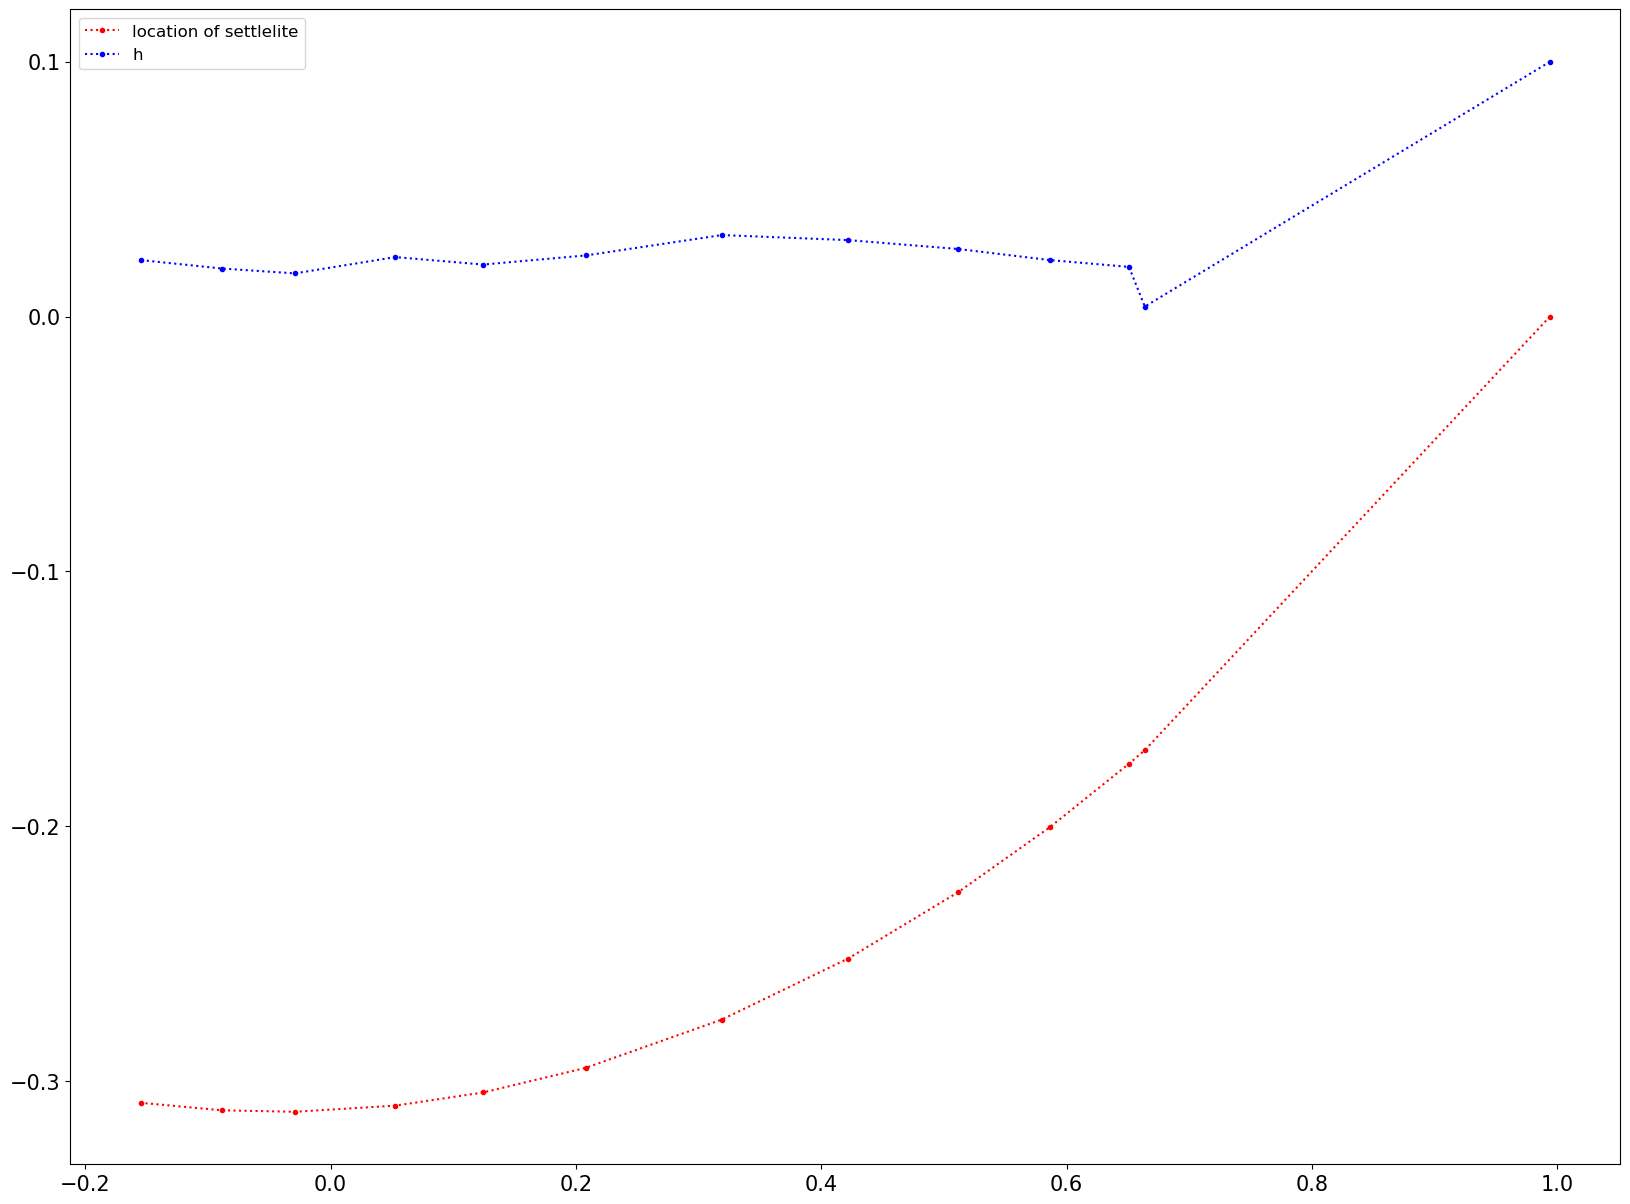

In [308]:
plt.figure(figsize=[10, 10])
plt.plot(xlist[:-220], ylist[:-220], ".:r",xlist[:-220], hs[:-220], ".:b")
plt.legend(["location of settlelite", "h"], fontsize=12)

plt.savefig("xandhs3.pdf")

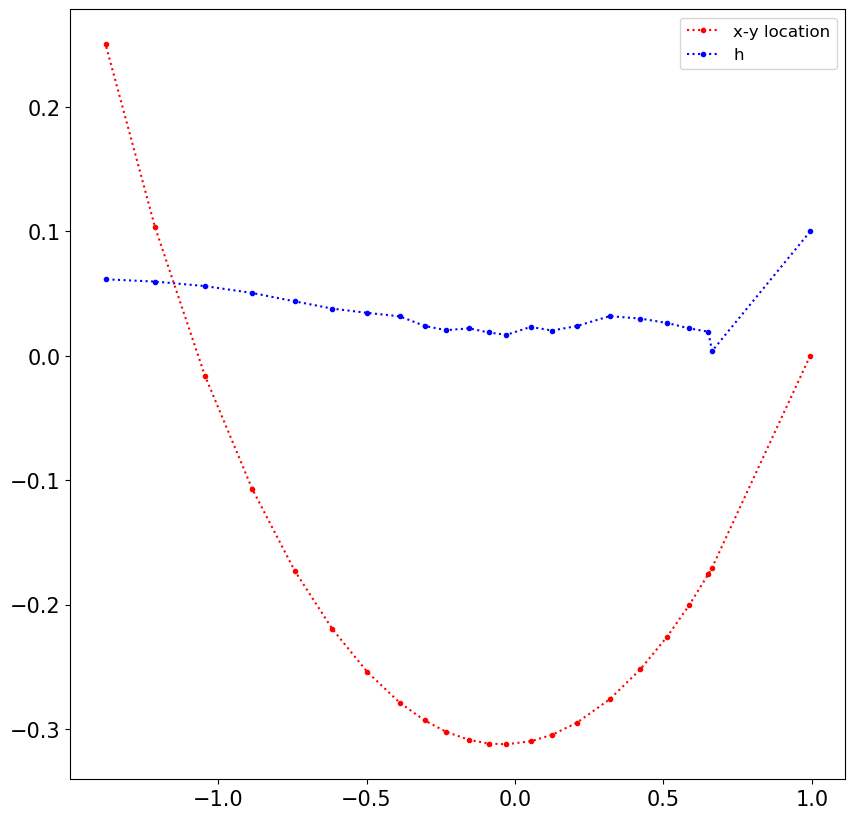

In [332]:
plt.figure(figsize=[10, 10])
plt.plot(xlist[:-210], ylist[:-210], ".:r",xlist[:-210], hs[:-210], ".:b")
plt.legend(["x-y location", "h"], fontsize=12)

plt.savefig("xandhs4.pdf")

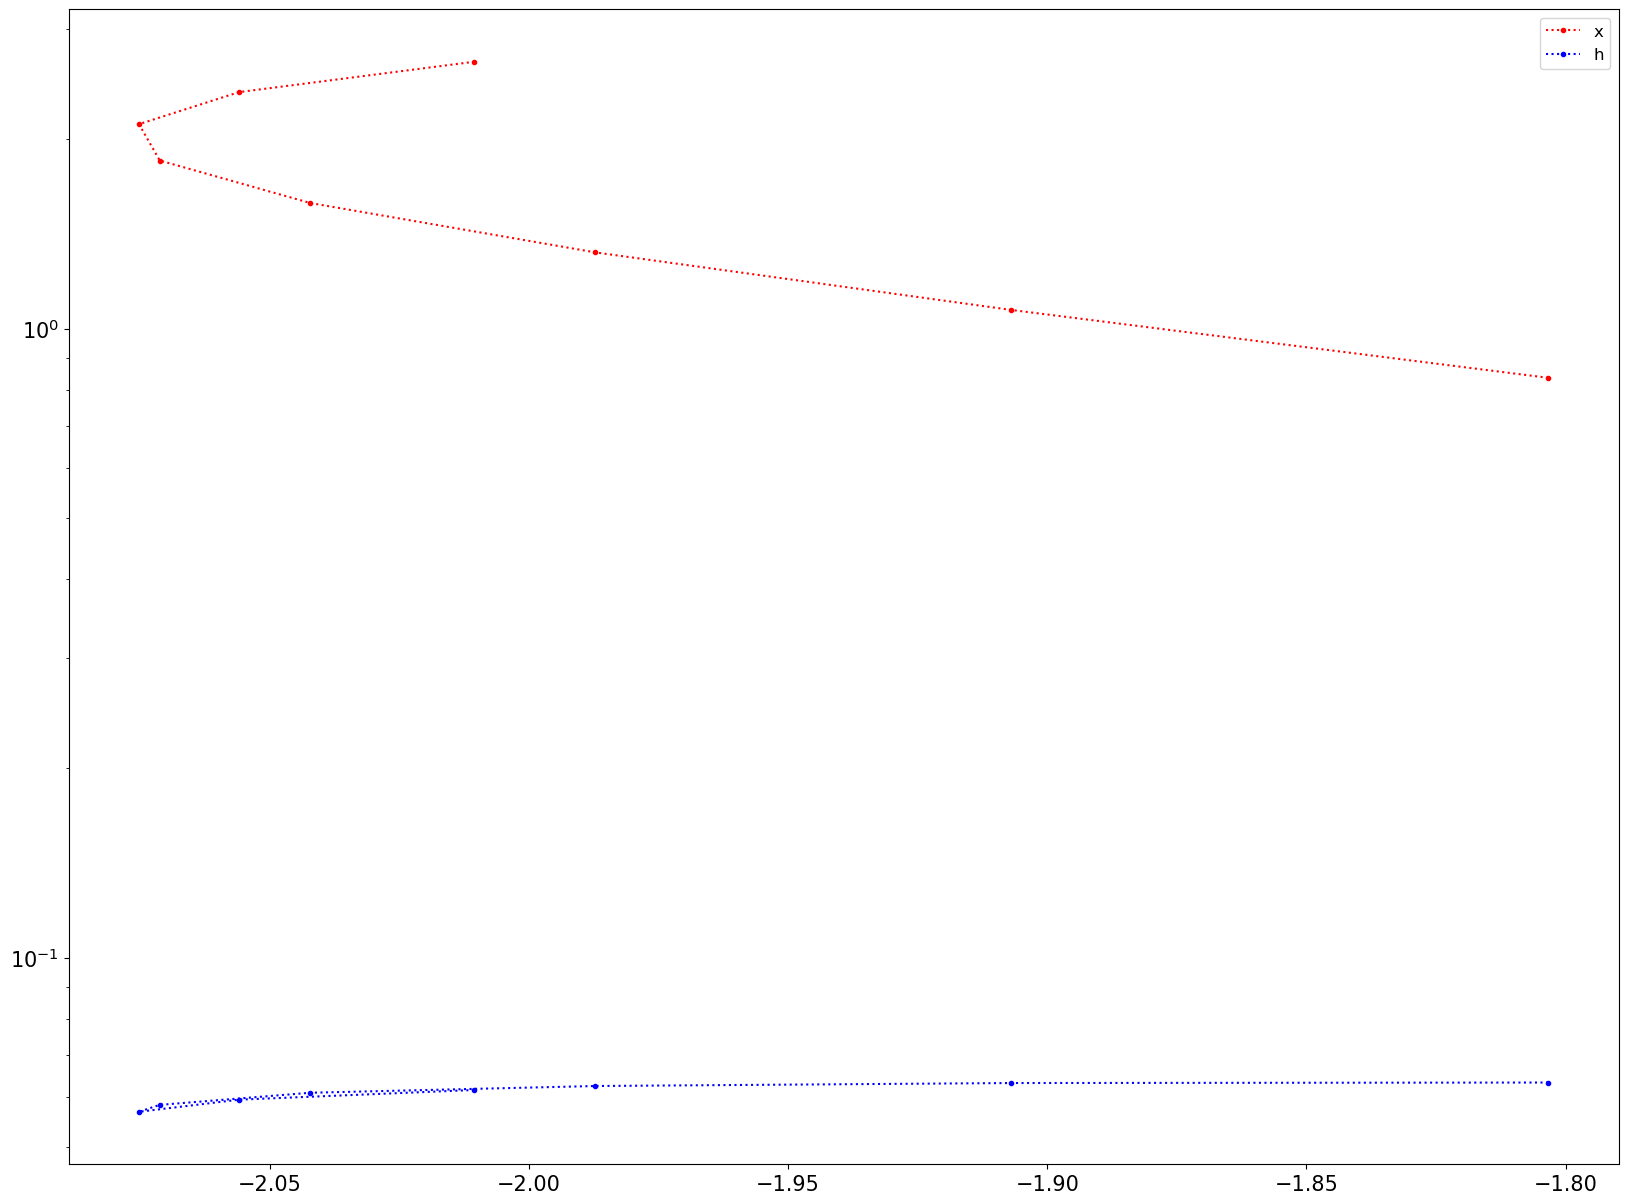

In [100]:
plt.figure(figsize=[20, 15])
plt.semilogy(xlist[25:-200], ylist[25:-200], ".:r",xlist[25:-200], hs[25:-200], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

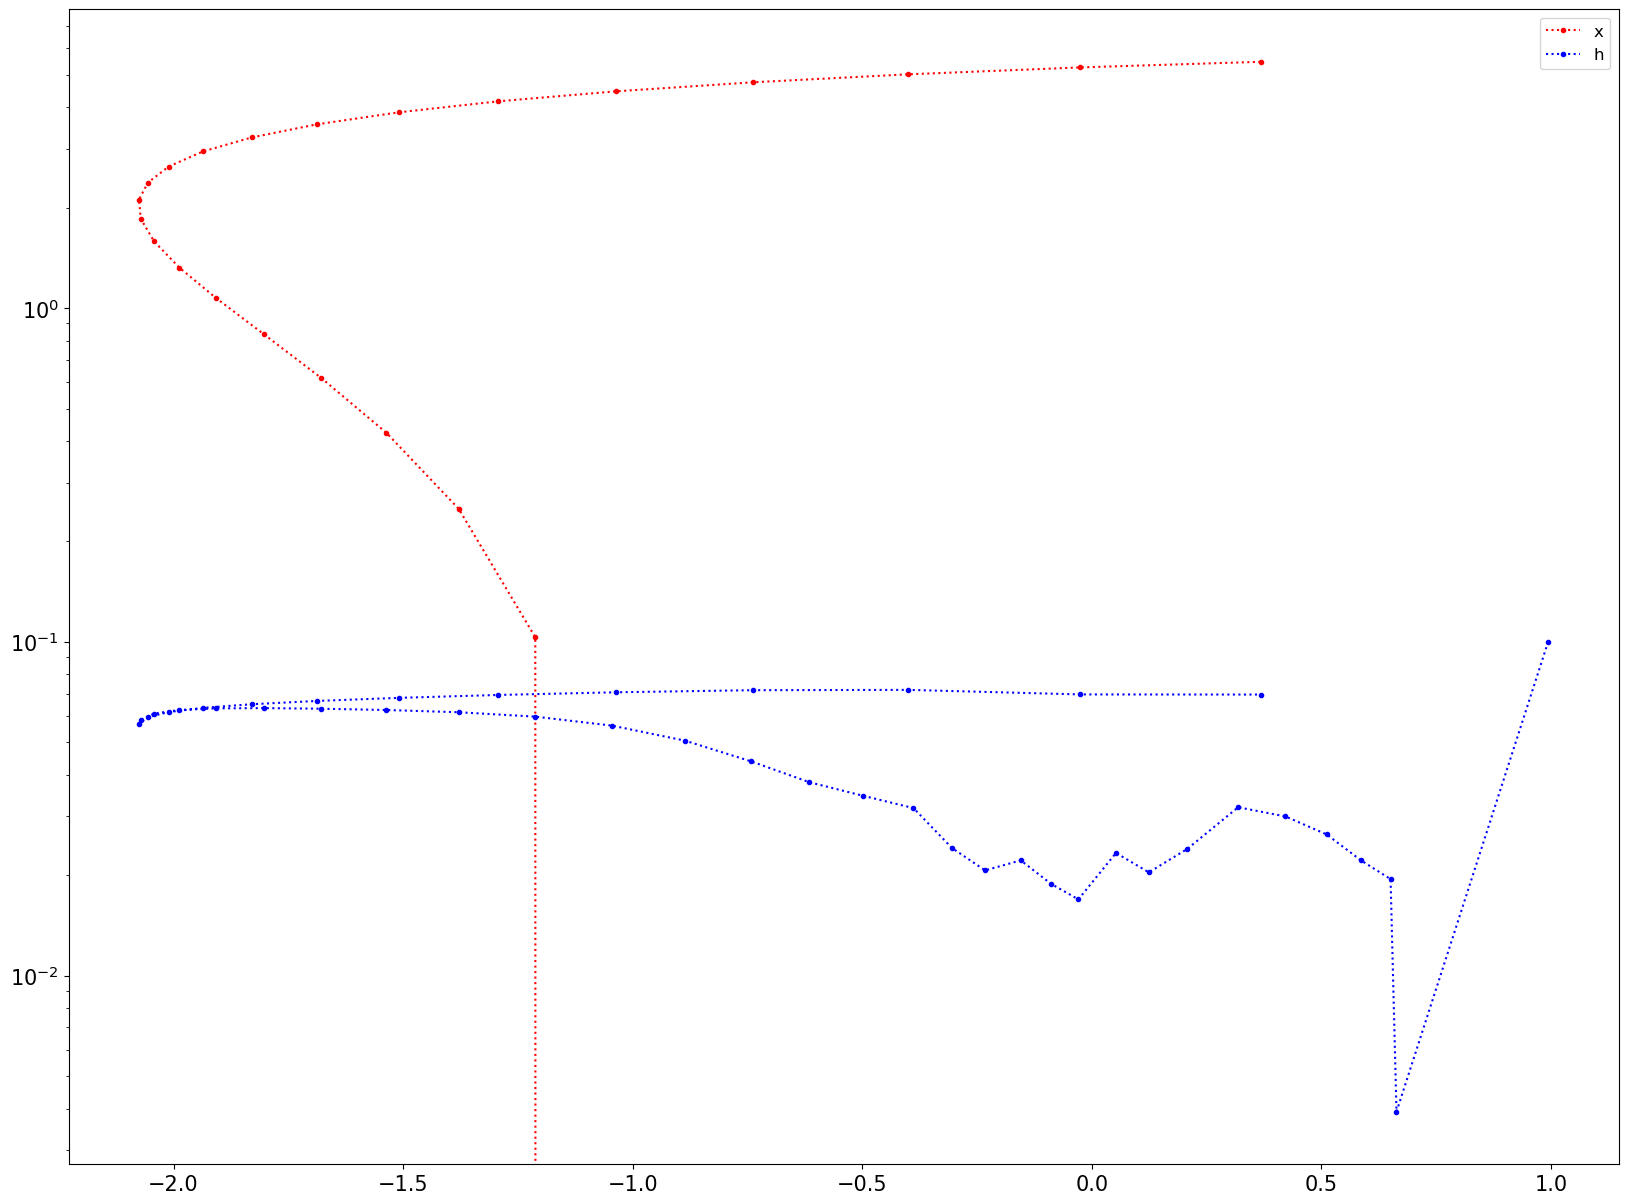

In [97]:
plt.figure(figsize=[20, 15])
plt.semilogy(xlist[:-190], ylist[:-190], ".:r",xlist[:-190], hs[:-190], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

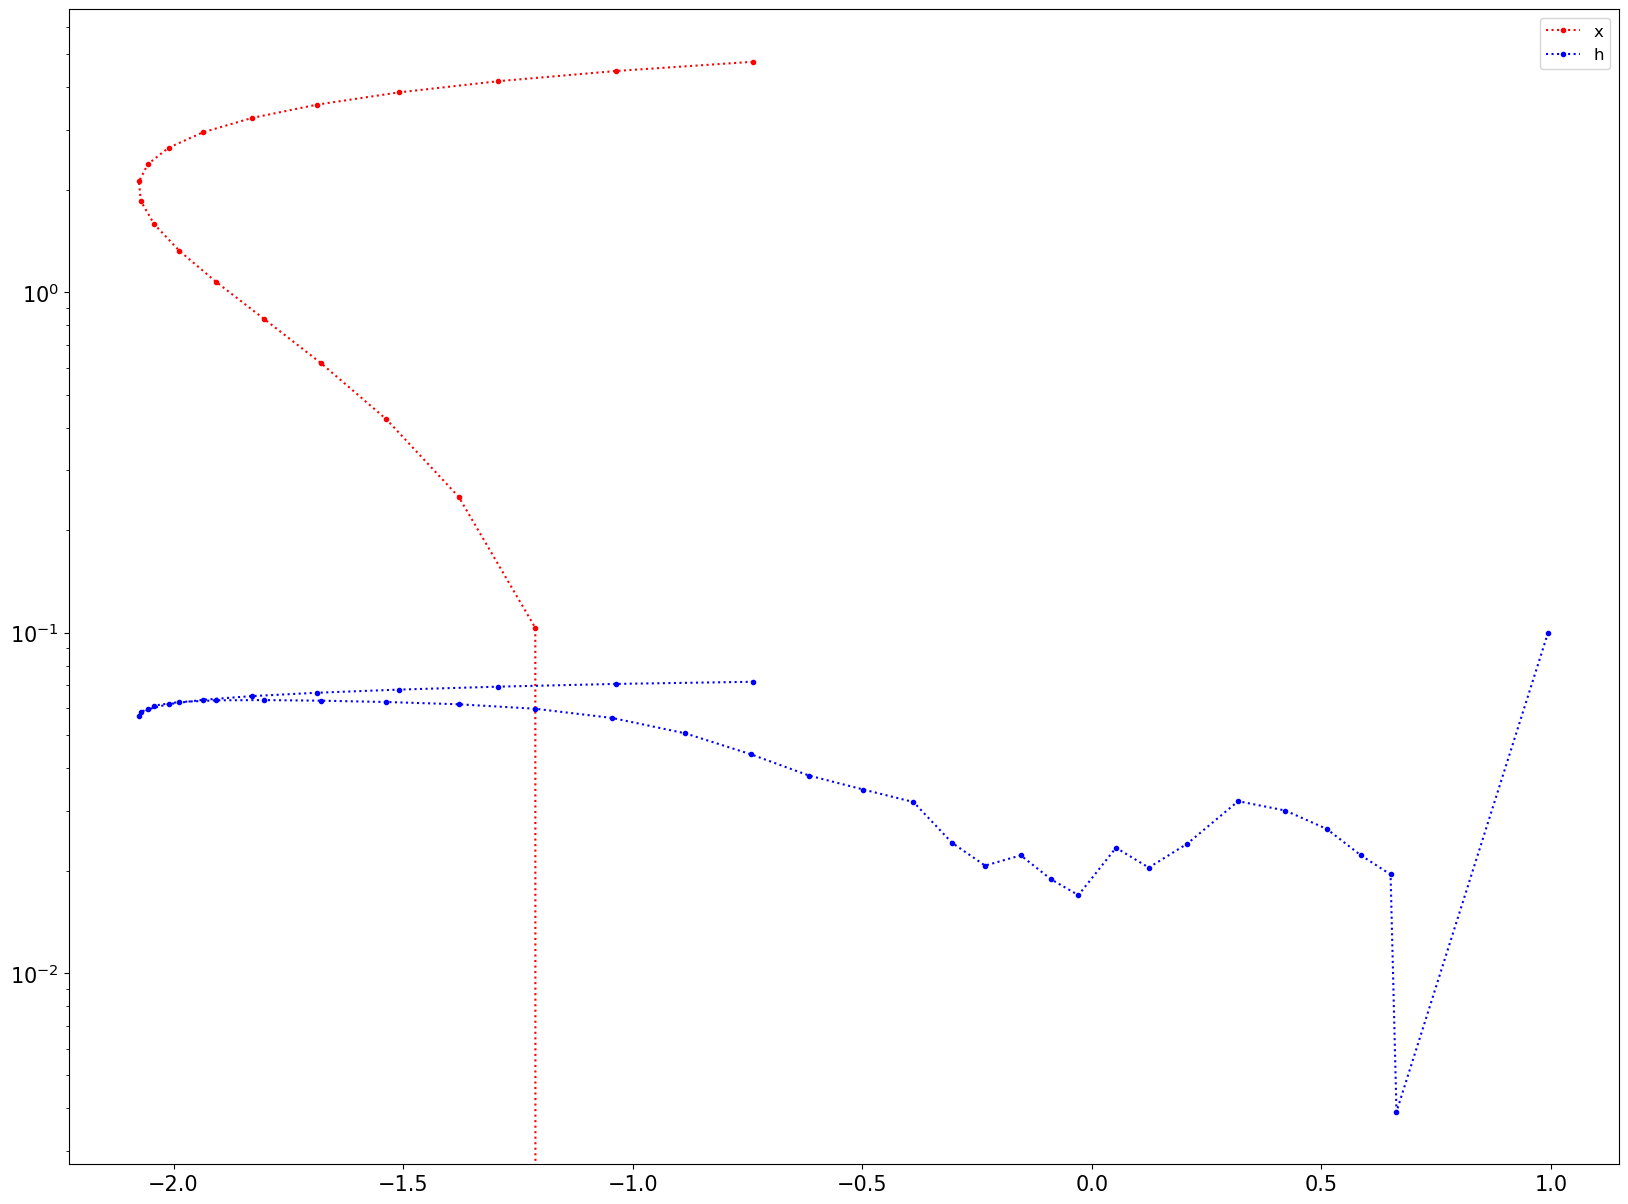

In [131]:
plt.figure(figsize=[20, 15])
a = 0
b = 40
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

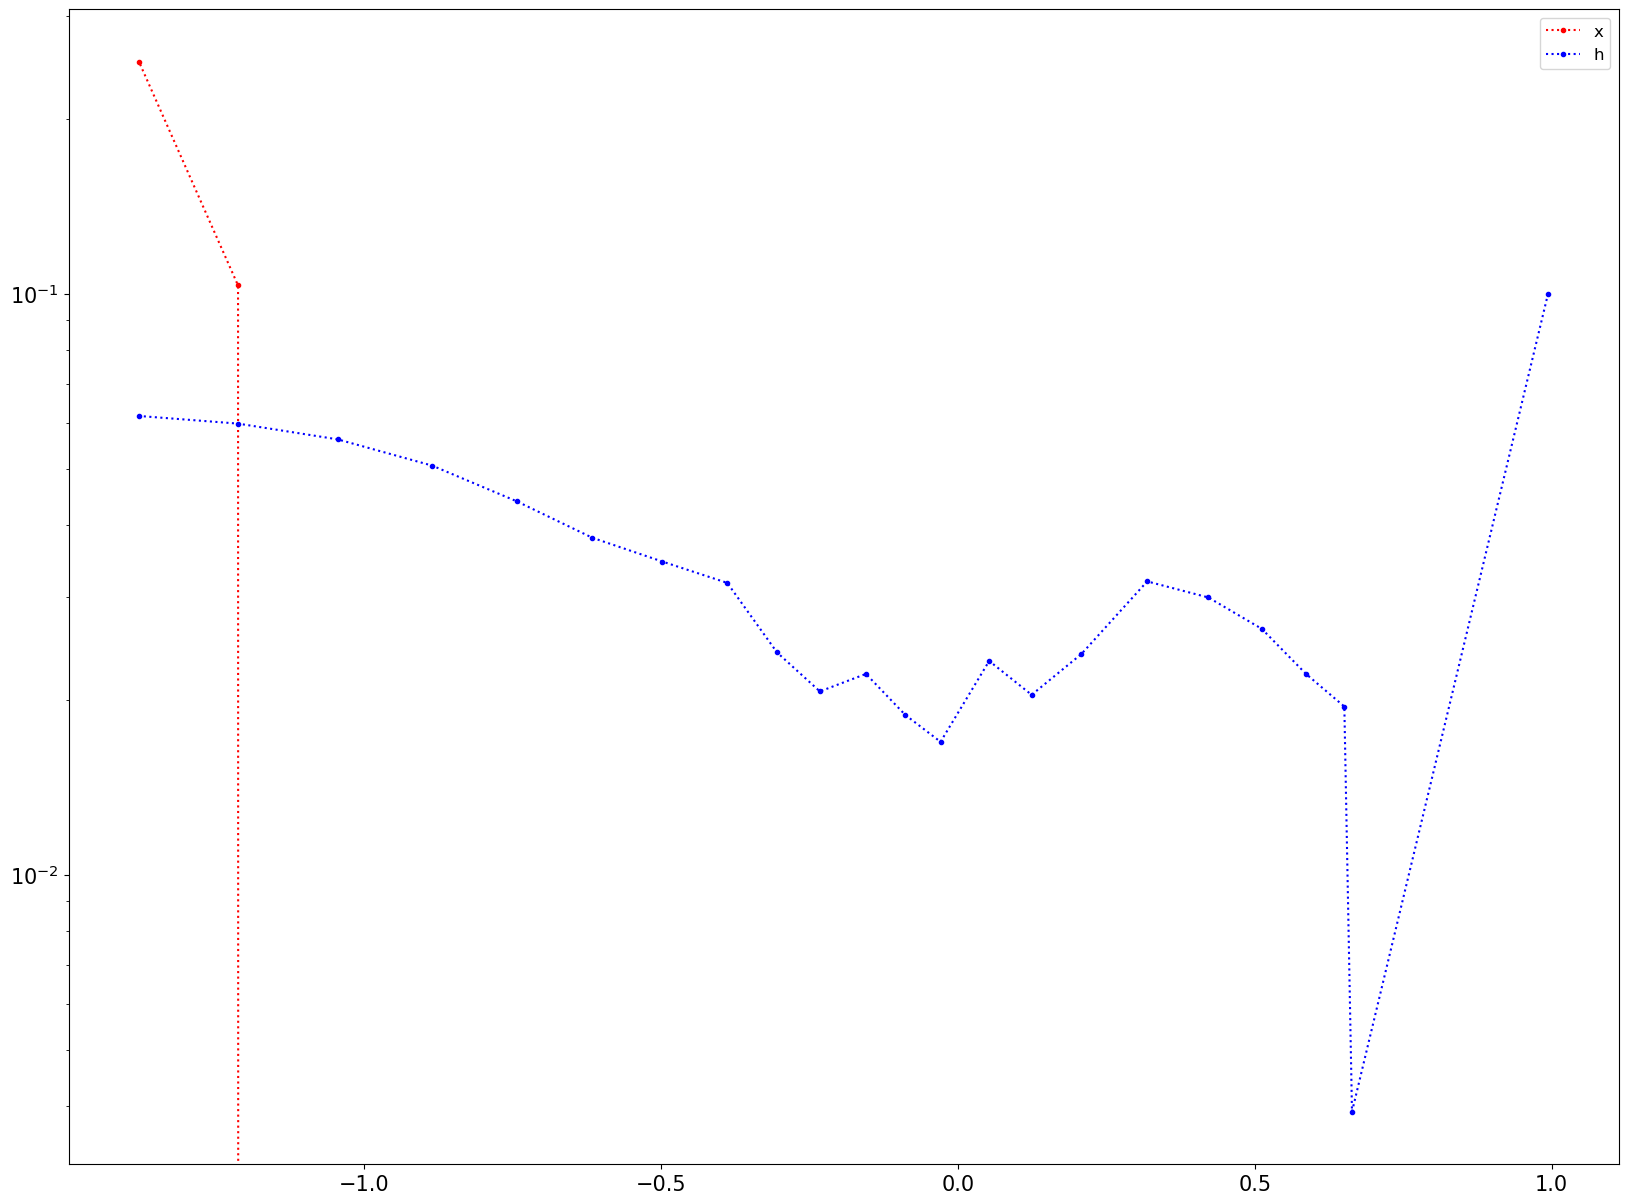

In [132]:
plt.figure(figsize=[20, 15])
a = 0
b = 23
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

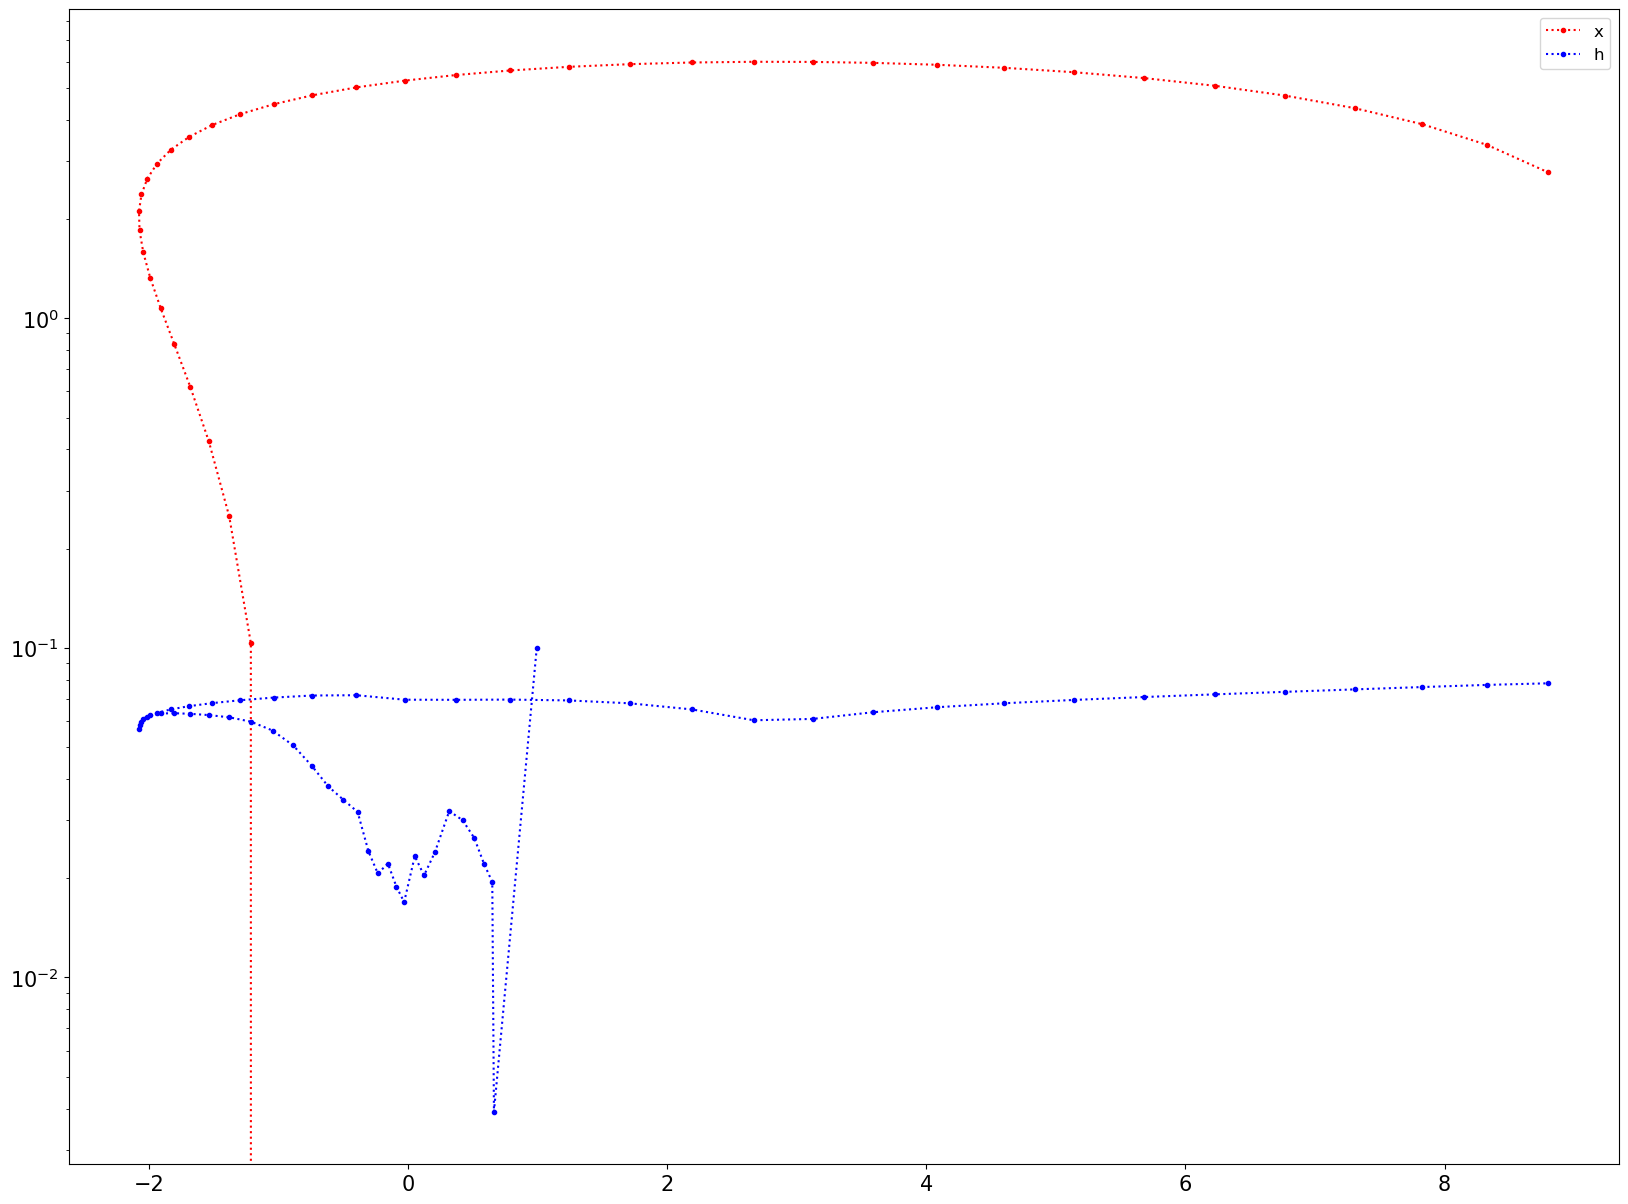

In [135]:
plt.figure(figsize=[20, 15])
a = 0
b = 60
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

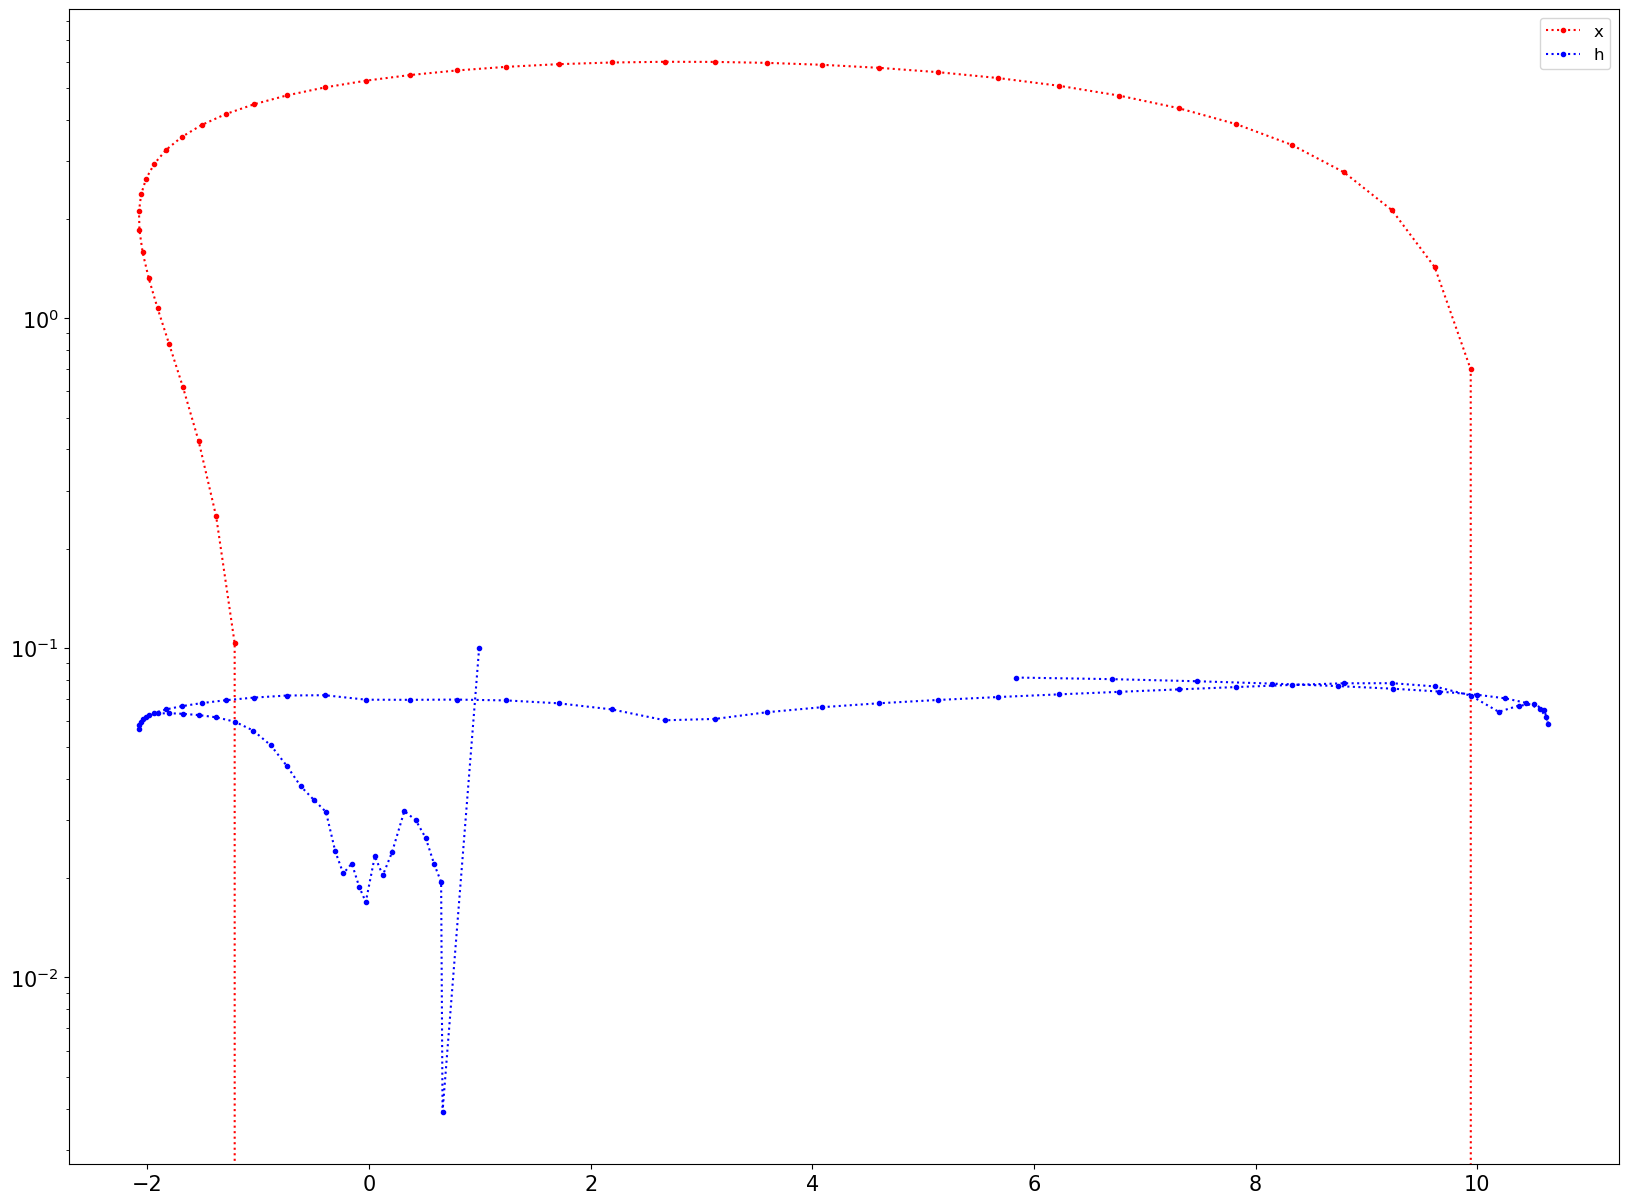

In [137]:
plt.figure(figsize=[20, 15])
a = 0
b = 80
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

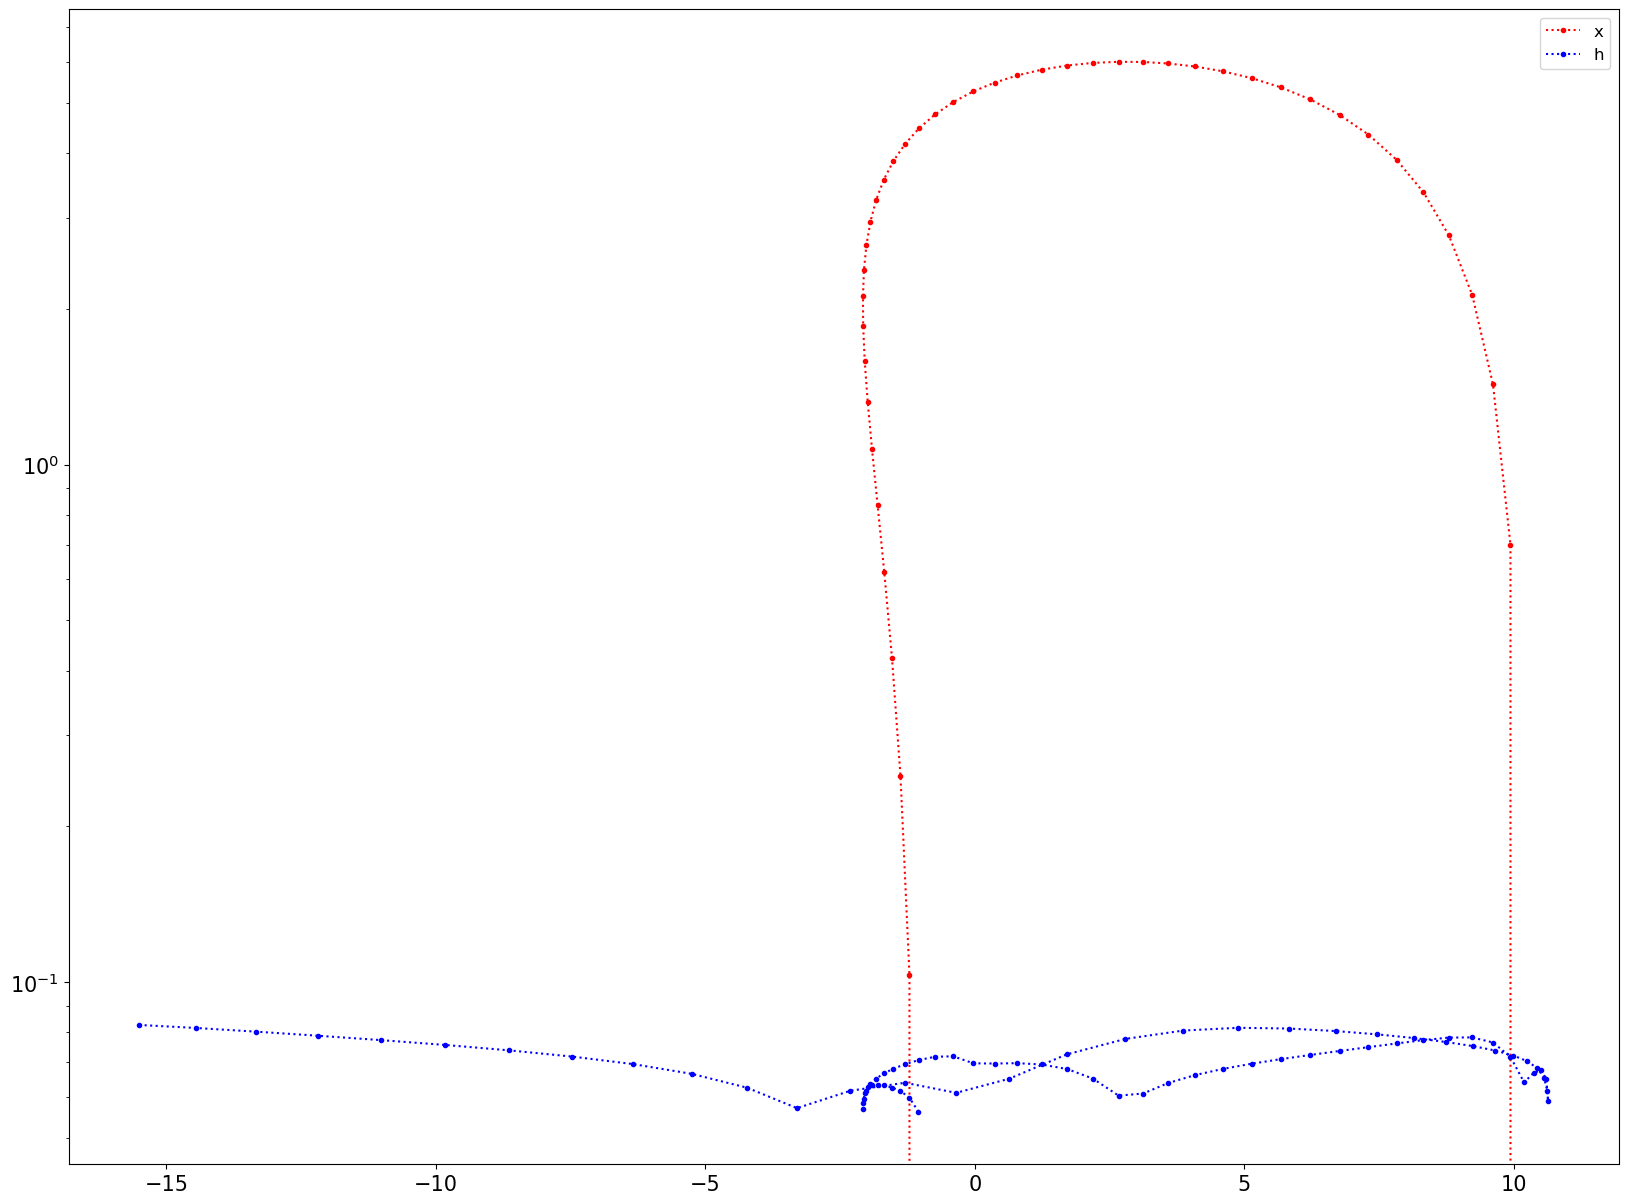

In [146]:
plt.figure(figsize=[20, 15])
a = 20
b = 100
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

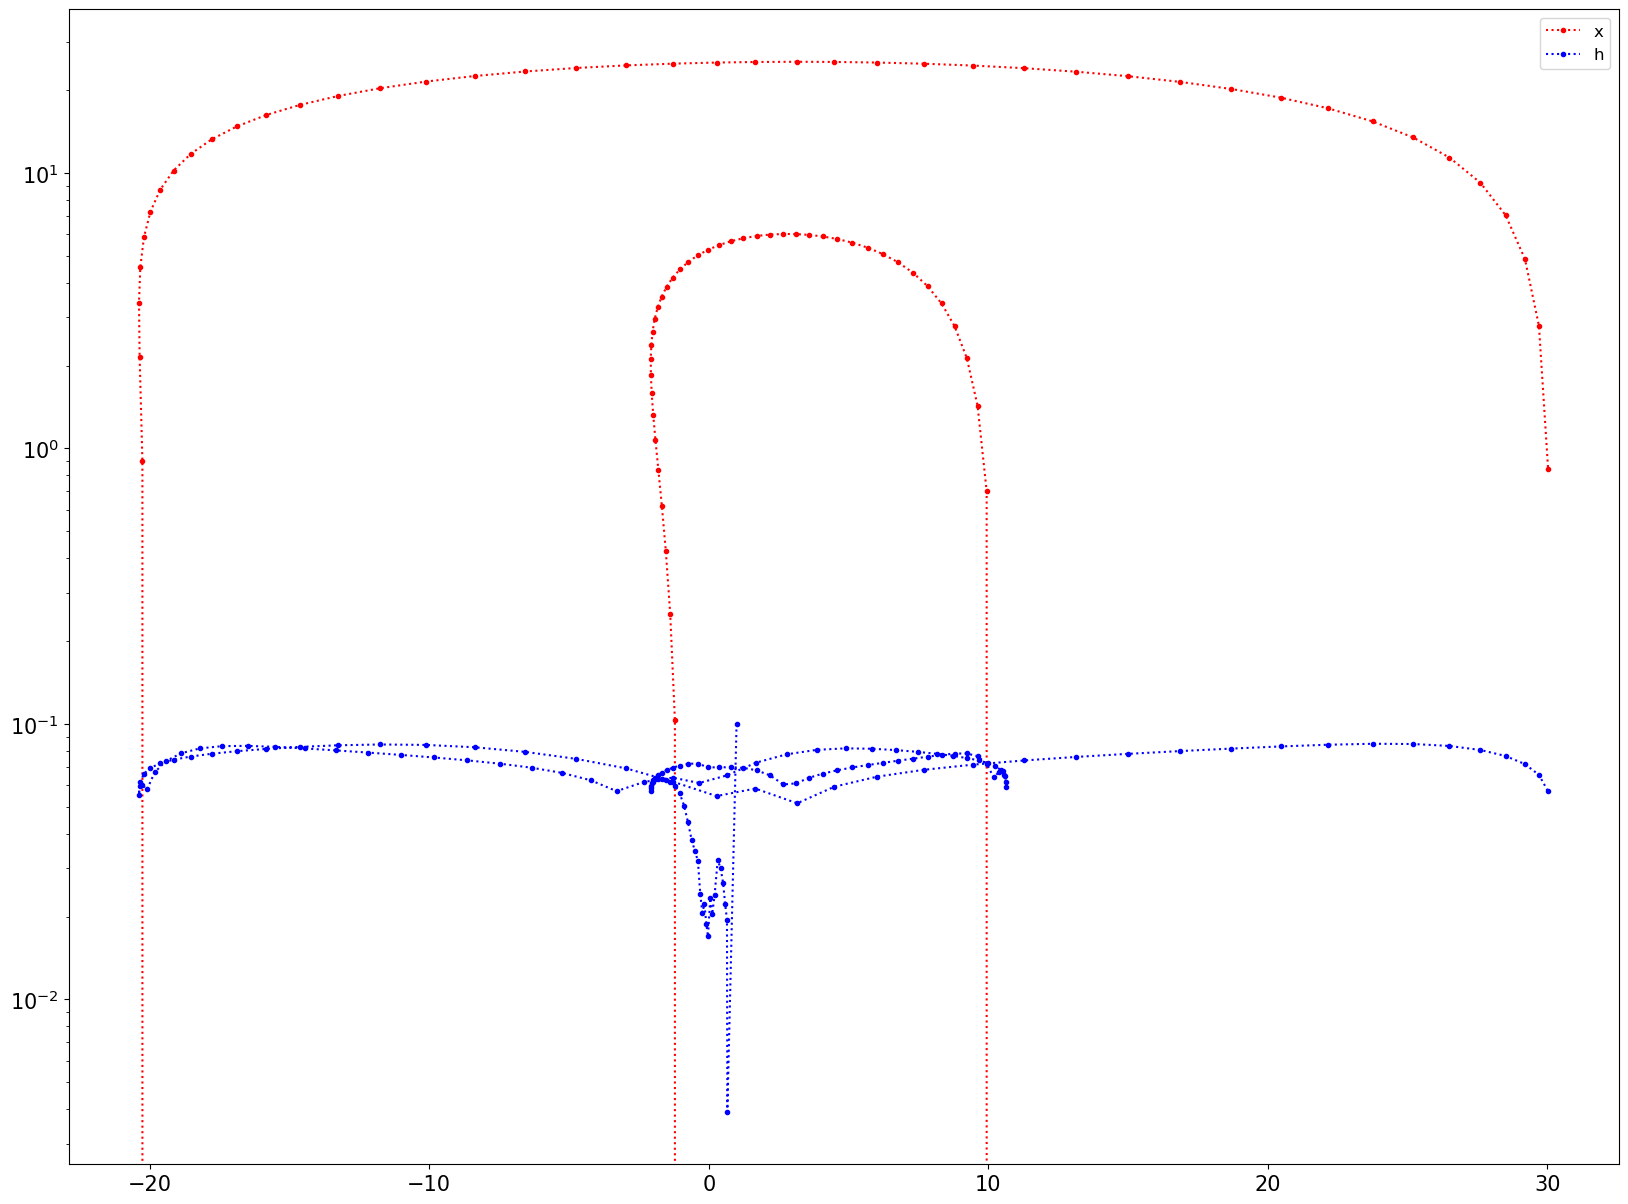

In [141]:
plt.figure(figsize=[20, 15])
a = 0
b = 150
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

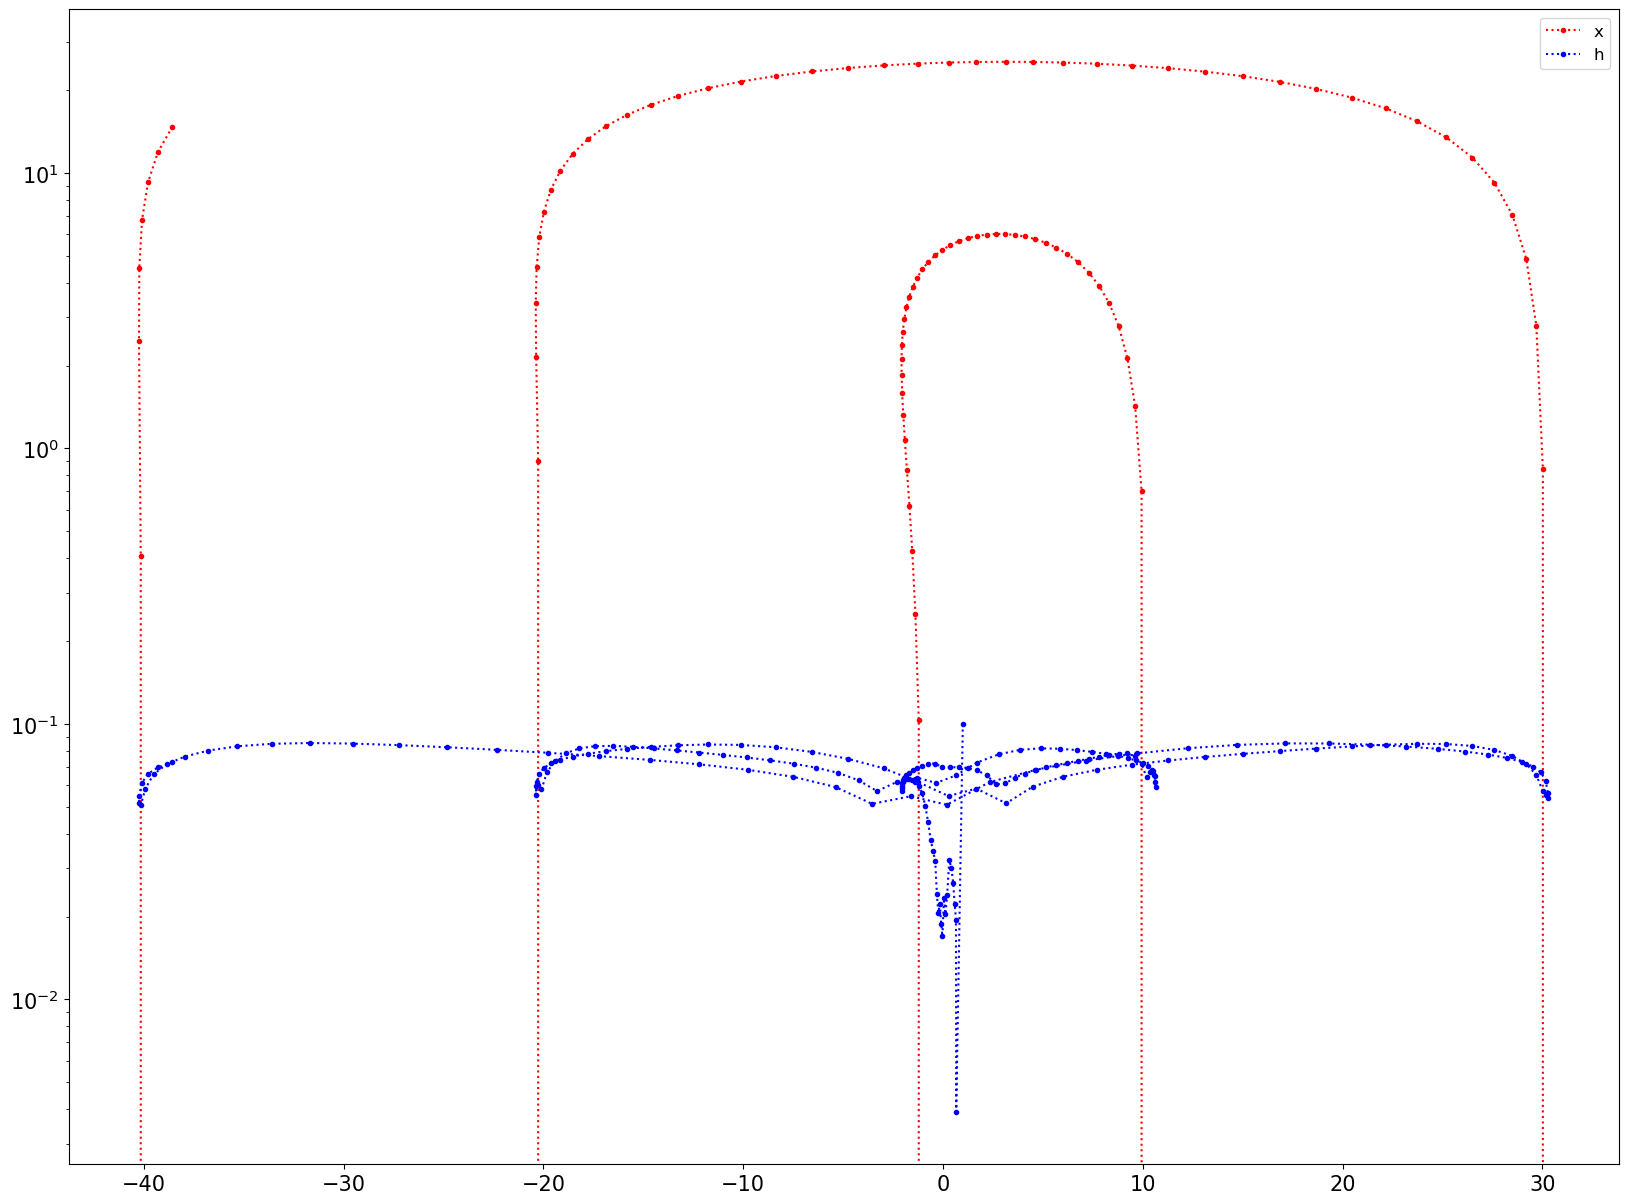

In [147]:
plt.figure(figsize=[20, 15])
a = 0
b = 200
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

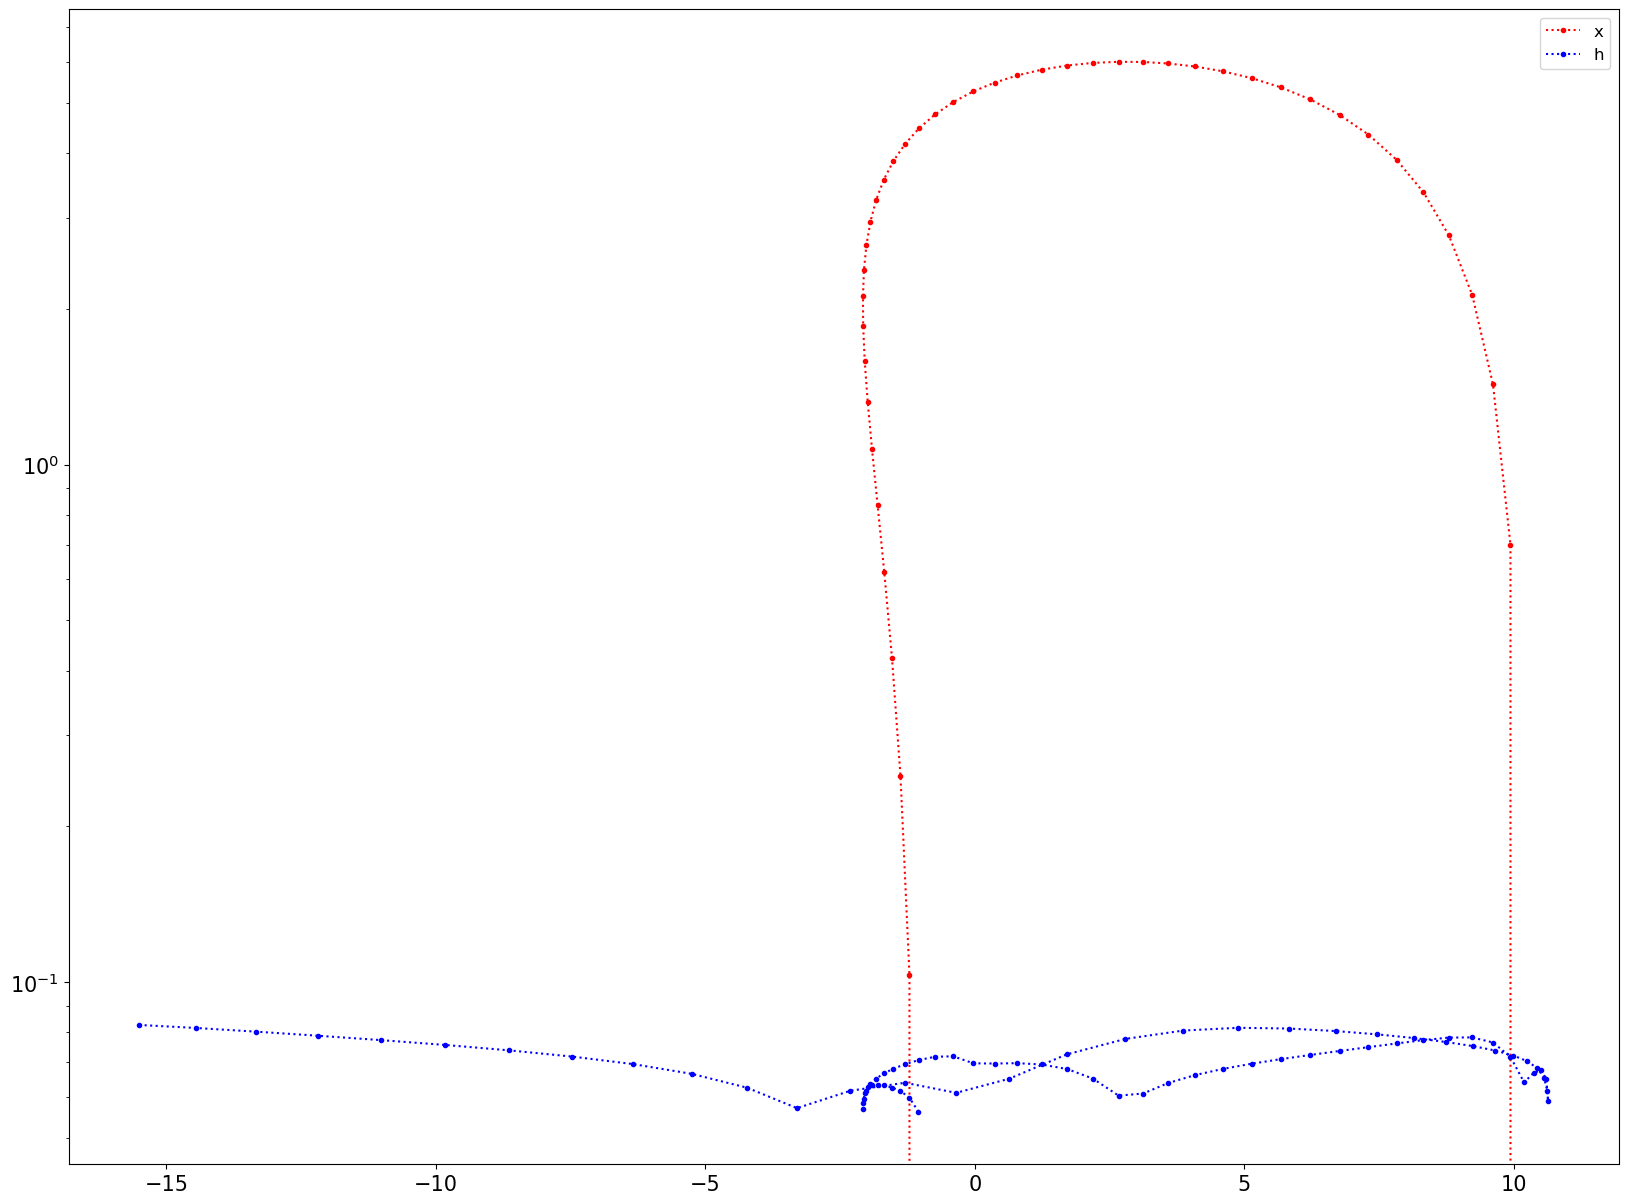

In [148]:
plt.figure(figsize=[20, 15])
a = 20
b = 100
plt.semilogy(xlist[a:b], ylist[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")
plt.legend(["x", "h"], fontsize=12)

plt.show()

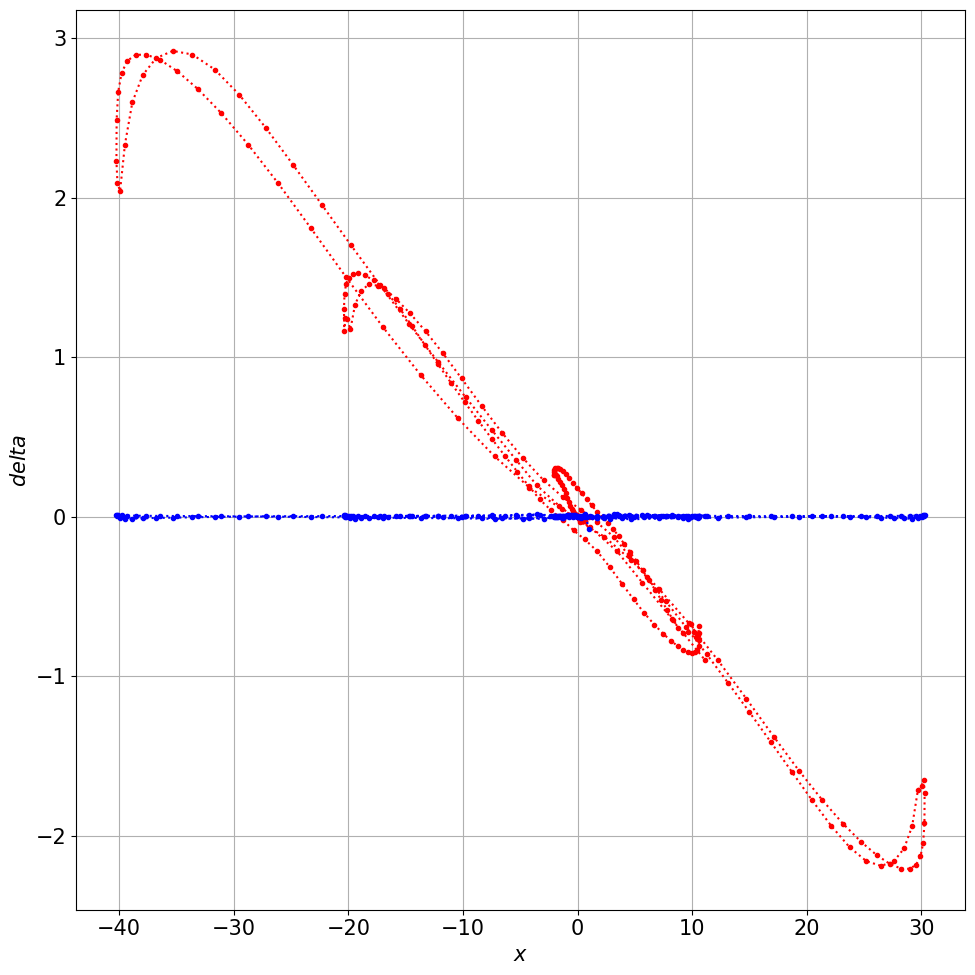

In [221]:
h_list = hs #hs 넣어주기
ylist_list = ylist # ylist 넣어주기
#ylist_list[2:] - ylist_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
ylist_2 = ylist_list[2:] # 2부터 시작하는 리스트
ylist_2 = np.append(ylist_2, ylist_list[-1]) # 마지막 요소 추가
diff_ylist_err = []
a = 0
b = 220

for i, j in zip(ylist_2, ylist_list[1:]):
    diff_ylist_err.append(i - j)

h_list_2 = h_list[2:]
h_list_2.append(h_list[-1])
diff_h_list = []

for i, j in zip(h_list_2, h_list):
    diff_h_list.append(i - j)
    
#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(xlist[a:b], diff_ylist_err[a:b], ".:r",xlist[a:b], diff_h_list[a:b], ".:b")


plt.grid()
plt.xlabel("$x$")
plt.ylabel("$delta$")
#plt.title("h & rel_{err} Graph")

plt.tight_layout()
plt.show()

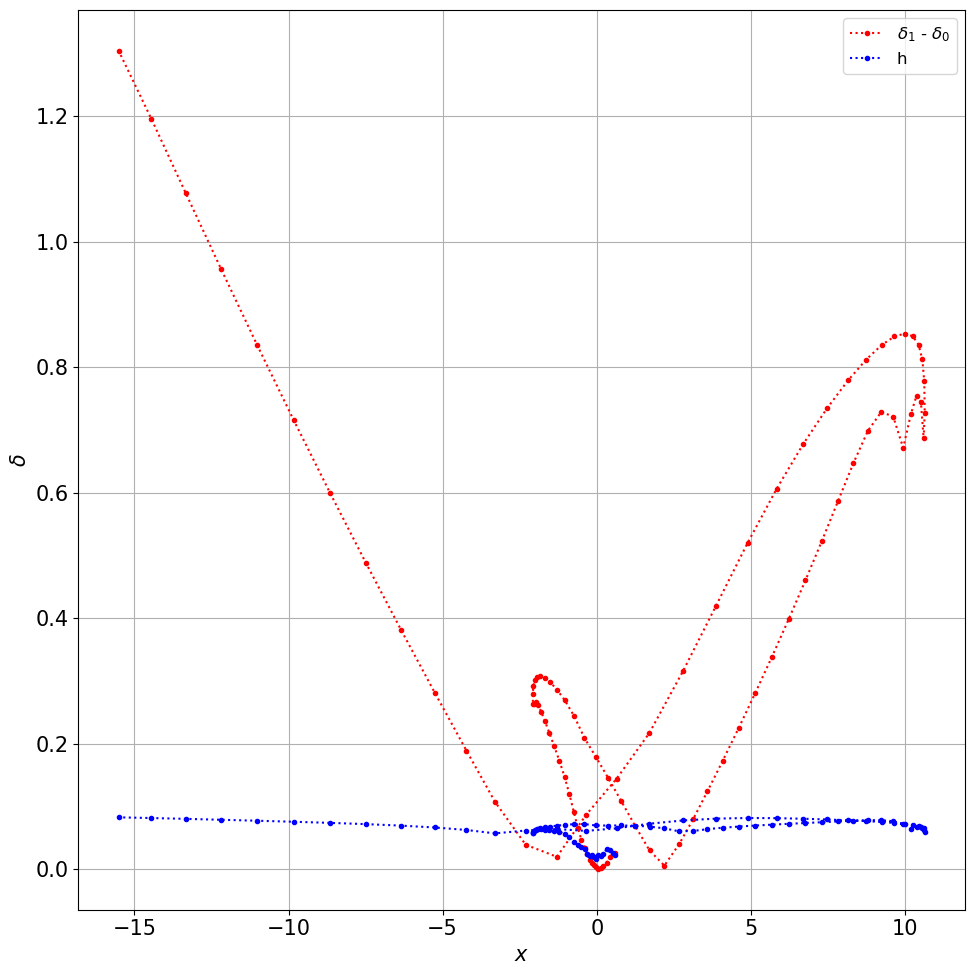

In [219]:
h_list = hs #hs 넣어주기
ylist_list = ylist # ylist 넣어주기
#ylist_list[2:] - ylist_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
ylist_2 = ylist_list[2:] # 2부터 시작하는 리스트
ylist_2 = np.append(ylist_2, ylist_list[-1]) # 마지막 요소 추가
diff_ylist_err = []
a = 3
b = 100
"""
0:3일때 증가하는 이유는 3이될때, 0.02보다 작아지면서 h값이 max 함수로 인해 고정된 0.02보다 큰 값을 가지게됨.

"""
for i, j in zip(ylist_2, ylist_list[1:]):
    diff_ylist_err.append(abs(i - j))

h_list_2 = h_list[2:]
h_list_2.append(h_list[-1])
diff_h_list = []

for i, j in zip(h_list_2, h_list):
    diff_h_list.append(i - j)
    
#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.plot(xlist[a:b], diff_ylist_err[a:b], ".:r",xlist[a:b], hs[a:b], ".:b")


plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\delta$")
#plt.title("h & rel_{err} Graph")
plt.legend(["$\delta_{1}$ - $\delta_{0}$", "h"], fontsize=12)
plt.tight_layout()
plt.show()

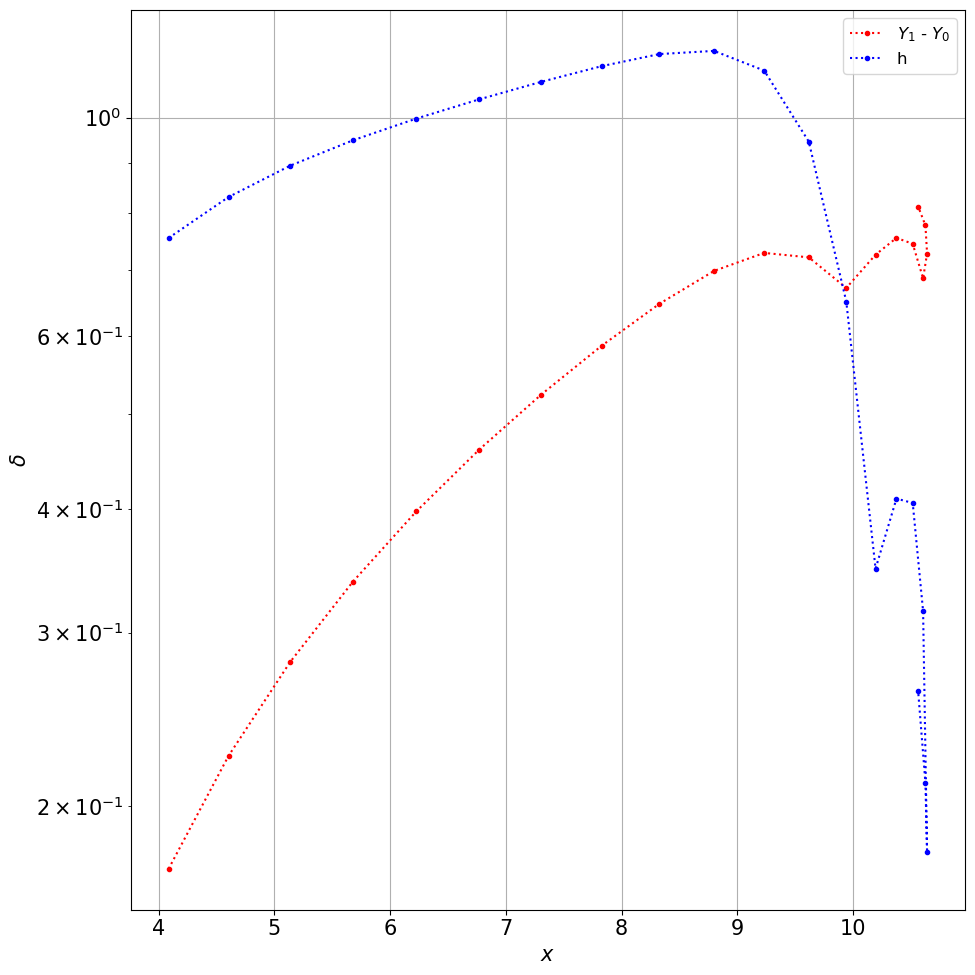

In [324]:
h_list = hs #hs 넣어주기
ylist_list = ylist # ylist 넣어주기
#ylist_list[2:] - ylist_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
ylist_2 = ylist_list[2:] # 2부터 시작하는 리스트
ylist_2 = np.append(ylist_2, ylist_list[-1]) # 마지막 요소 추가
diff_ylist_err = []
a = 50
b = 70
"""
0:3일때 증가하는 이유는 3이될때, 0.02보다 작아지면서 h값이 max 함수로 인해 고정된 0.02보다 큰 값을 가지게됨.

"""
for i, j in zip(ylist_2, ylist_list[1:]):
    diff_ylist_err.append(abs(i - j))

h_list_2 = h_list[2:]
h_list_2.append(h_list[-1])
diff_h_list = []

for i, j in zip(h_list_2, h_list):
    diff_h_list.append(i - j)
    
#rel_err_list[2:] - rel_err_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
rel_err_2 = rel_err_list[2:] # 2부터 시작하는 리스트
rel_err_2.append(rel_err_list[-1]) # 마지막 요소 추가
diff_rel_err = []

for i, j in zip(rel_err_2, rel_err_list[1:]):
    diff_rel_err.append(i - j)

    
#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.semilogy(xlist[a:b], diff_ylist_err[a:b], ".:r",xlist[a:b], rel_err_list[a:b], ".:b")


plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\delta$")
#plt.title("h & rel_{err} Graph")
plt.legend(["$Y_{1}$ - $Y_{0}$", "h"], fontsize=12)
plt.tight_layout()
plt.show()


In [245]:
xlim = 0, 
abstol = 1e-9
reltol = 1e-9
xs, ys, hs = embedded_rk4_ode_1(F, Y_init, h_init, tlim,
                           abstol=abstol, reltol=reltol,
                           hminmax=(1e-5, 1e5), max_iterations=10000)

xlist, ylist, vxlist, vylist = map(np.array, zip(*ys))


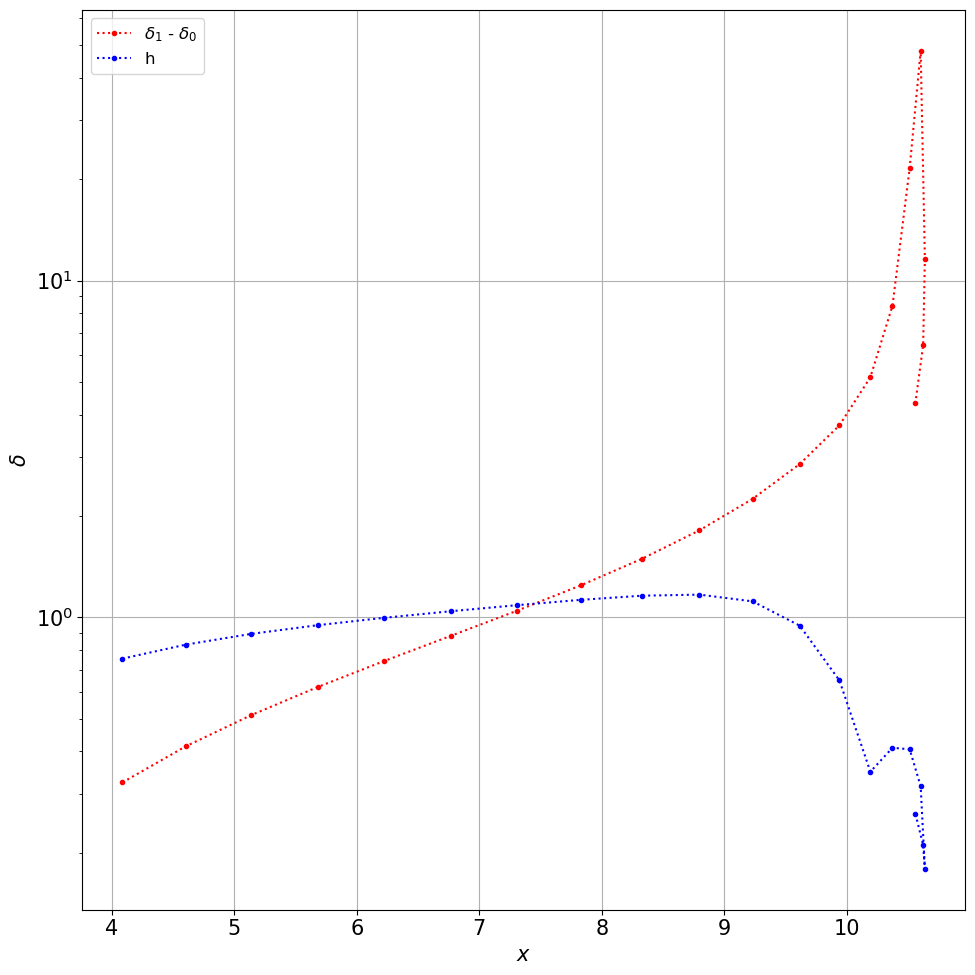

In [323]:
h_list = hs #hs 넣어주기
ylist_list = ylist # ylist 넣어주기
#ylist_list[2:] - ylist_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
ylist_2 = ylist_list[2:] # 2부터 시작하는 리스트
ylist_2 = np.append(ylist_2, ylist_list[-1]) # 마지막 요소 추가
diff_ylist_err = []
a = 50
b = 70
"""
0:3일때 증가하는 이유는 3이될때, 0.02보다 작아지면서 h값이 max 함수로 인해 고정된 0.02보다 큰 값을 가지게됨.

"""
for i, j in zip(ylist_2, ylist_list[1:]):
    diff_ylist_err.append(abs(i - j))

h_list_2 = h_list[2:]
h_list_2.append(h_list[-1])
diff_h_list = []

for i, j in zip(h_list_2, h_list):
    diff_h_list.append(i - j)
    
#rel_err_list[2:] - rel_err_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
rel_err_2 = rel_err_list[2:] # 2부터 시작하는 리스트
rel_err_2.append(rel_err_list[-1]) # 마지막 요소 추가
diff_rel_err = []

for i, j in zip(rel_err_2, rel_err_list[1:]):
    diff_rel_err.append(i - j)

    
#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.semilogy(xlist[a:b], grad[a:b], ".:r",xlist[a:b], rel_err_list[a:b], ".:b")


plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\delta$")
#plt.title("h & rel_{err} Graph")
plt.legend(["$\delta_{1}$ - $\delta_{0}$", "h"], fontsize=12)
plt.tight_layout()
plt.show()


/var/folders/kk/2pj93ygs67nbx9_42r_c6_3c0000gn/T/ipykernel_50594/1763612252.py:26: RuntimeWarning: invalid value encountered in double_scalars
  grad.append(j / i)


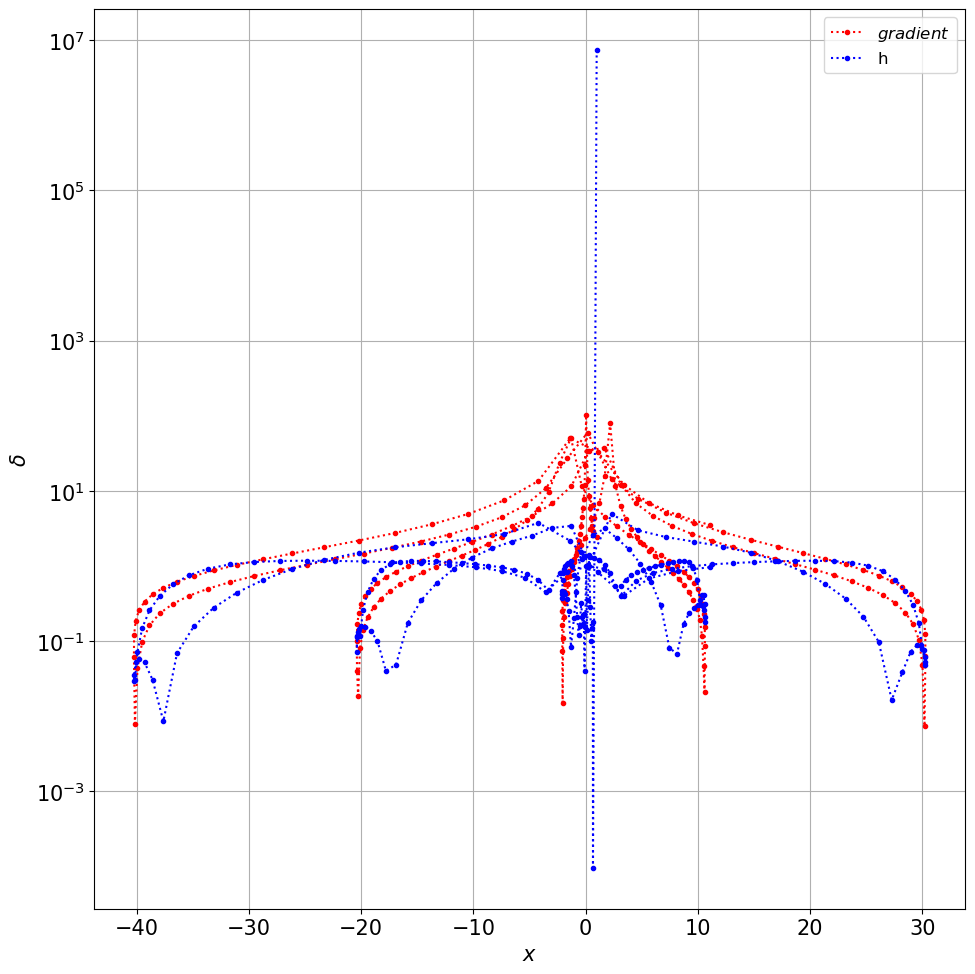

In [330]:
h_list = hs #hs 넣어주기
ylist_list = ylist # ylist 넣어주기
xlist_list = xlist # ylist 넣어주기

xlist_2 = xlist_list[2:] # 2부터 시작하는 리스트
xlist_2 = np.append(xlist_2, xlist_list[-1]) # 마지막 요소 추가
diff_xlist_err = []

ylist_2 = ylist_list[2:] # 2부터 시작하는 리스트
ylist_2 = np.append(ylist_2, ylist_list[-1]) # 마지막 요소 추가
diff_ylist_err = []
a = 0
b = 220
"""
0:3일때 증가하는 이유는 3이될때, 0.02보다 작아지면서 h값이 max 함수로 인해 고정된 0.02보다 큰 값을 가지게됨.

"""
for i, j in zip(ylist_2, ylist_list[1:]):
    diff_xlist_err.append(abs(i - j))

for i, j in zip(xlist_2, xlist_list[1:]):
    diff_ylist_err.append(abs(i - j))

grad = []
for i, j in zip(diff_xlist_err, diff_ylist_err):
    grad.append(j / i)
    
for i, j in zip(h_list_2, h_list):
    diff_h_list.append(i - j)
    
#rel_err_list[2:] - rel_err_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
rel_err_2 = rel_err_list[2:] # 2부터 시작하는 리스트
rel_err_2.append(rel_err_list[-1]) # 마지막 요소 추가
diff_rel_err = []

for i, j in zip(rel_err_2, rel_err_list[1:]):
    diff_rel_err.append(i - j)

    
#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.semilogy(xlist[a:b], grad[a:b], ".:r",xlist[a:b], rel_err_list[a:b], ".:b")


plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\delta$")
#plt.title("h & rel_{err} Graph")
plt.legend(["$gradient$", "h"], fontsize=12)
plt.tight_layout()
plt.savefig("xandhs5.pdf")

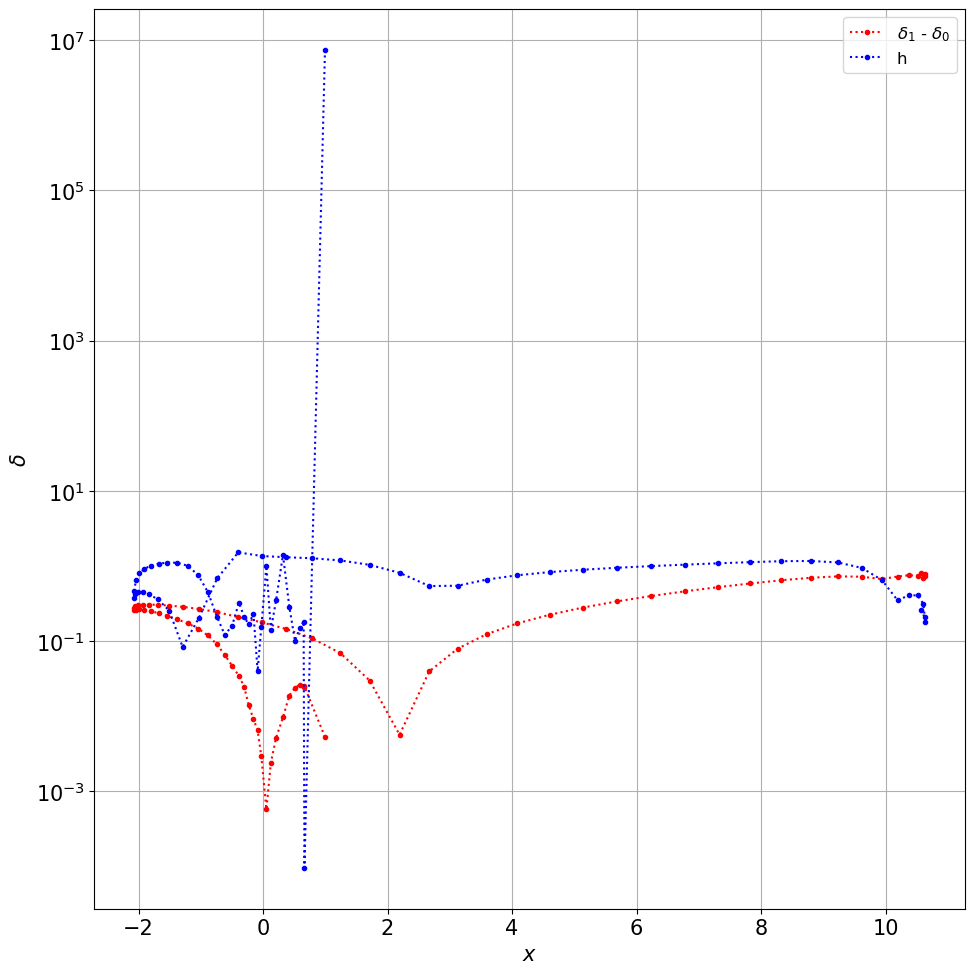

In [261]:
h_list = hs #hs 넣어주기
ylist_list = ylist # ylist 넣어주기
#ylist_list[2:] - ylist_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
ylist_2 = ylist_list[2:] # 2부터 시작하는 리스트
ylist_2 = np.append(ylist_2, ylist_list[-1]) # 마지막 요소 추가
diff_ylist_err = []
a = 0
b = 70
"""
0:3일때 증가하는 이유는 3이될때, 0.02보다 작아지면서 h값이 max 함수로 인해 고정된 0.02보다 큰 값을 가지게됨.

"""
for i, j in zip(ylist_2, ylist_list[1:]):
    diff_ylist_err.append(abs(i - j))

h_list_2 = h_list[2:]
h_list_2.append(h_list[-1])
diff_h_list = []

for i, j in zip(h_list_2, h_list):
    diff_h_list.append(i - j)
    
#rel_err_list[2:] - rel_err_list[1:] 값 구하는데, 처음이 크니까 같은 값 하나 늘려주기.
rel_err_2 = rel_err_list[2:] # 2부터 시작하는 리스트
rel_err_2.append(rel_err_list[-1]) # 마지막 요소 추가
diff_rel_err = []

for i, j in zip(rel_err_2, rel_err_list[1:]):
    diff_rel_err.append(i - j)

    
#Plotting (x, y)!!
plt.figure(figsize=[10, 10])
plt.semilogy(xlist[a:b], diff_ylist_err[a:b], ".:r",xlist[a:b], rel_err_list[a:b], ".:b")


plt.grid()
plt.xlabel("$x$")
plt.ylabel("$\delta$")
#plt.title("h & rel_{err} Graph")
plt.legend(["$\delta_{1}$ - $\delta_{0}$", "h"], fontsize=12)
plt.tight_layout()

